# Example 3: `intrinsic` applied to MNIST on SimCLR with resize and crop

In this example, we apply `intrinsic` to data representations of MNIST images obtained with SimCLR.

SimCLR transformations include:



```
transforms.Compose([
            transforms.RandomResizedCrop(size=size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=(0, 179)),
            transforms.RandomApply([transforms.ColorJitter(brightness=0.5,
                                        contrast=0.5,
                                        saturation=0.5,
                                        hue=0.1)], p=0.8),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.1307], std=[0.3081])
        ])
```

SimCLR loss on train: 1.03



Embeddings are available at: [google drive link](https://drive.google.com/drive/folders/1-1VDp09u1bw39J0in4vLCLf_-vRMrv1Q?usp=sharing)
\
We save embeddings on layers (see the full scheme below): `layer2_block2`, `layer3_block2`, `layer1_block2`, `layer4_block2`.

We calculate on each epoch for each saved layer:
*   Intrinsic dimension (by MLE, TwoNN)
*   Magnitude
*   Curvature
*   Persistence diagrams
*   Total persistence




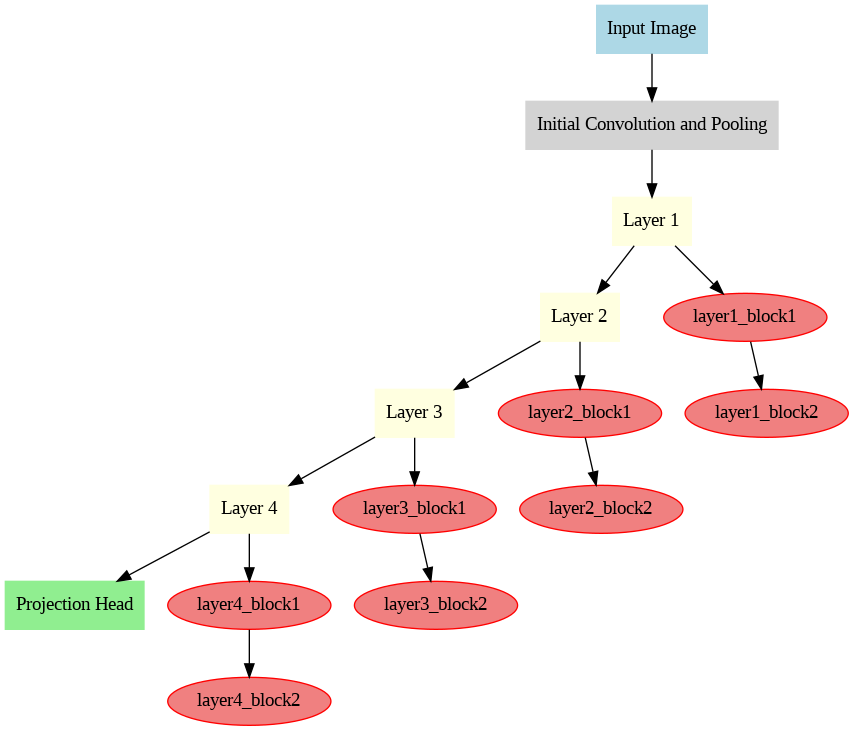

In [2]:
from IPython.display import Image
Image(filename='/content/simclr_full_diagram.png')

## Imports and installs

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import os


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# Import Google Drive and mount it
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## SimCLR

In [ ]:
save_path = '/content/drive/My Drive/embeddings_SimCLR_MNIST'
os.makedirs(save_path, exist_ok=True)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

class SimCLR(nn.Module):
    def __init__(self, base_model, projection_dim=128):
        super(SimCLR, self).__init__()
        self.base_model = base_model
        self.feature_dim = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()
        self.projection_head = nn.Sequential(
            nn.Linear(self.feature_dim, self.feature_dim),
            nn.ReLU(),
            nn.Linear(self.feature_dim, projection_dim)
        )
        self._init_hooks()
        self._init_weights()

    def _init_hooks(self):
        self.layer_outputs = {}
        def get_activation(name):
            def hook(model, input, output):
                self.layer_outputs[name] = output
            return hook

        # Register hooks for desired layers
        self.base_model.layer1[1].register_forward_hook(get_activation('layer1_block2'))
        self.base_model.layer2[1].register_forward_hook(get_activation('layer2_block2'))
        self.base_model.layer3[1].register_forward_hook(get_activation('layer3_block2'))
        self.base_model.layer4[1].register_forward_hook(get_activation('layer4_block2'))
        self.base_model.avgpool.register_forward_hook(get_activation('avgpool'))

    def _init_weights(self):
        for m in self.projection_head.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        self.layer_outputs = {}  # Reset stored outputs
        features = self.base_model(x)
        projections = self.projection_head(features)
        return projections, features

class SimCLRTransform:
    def __init__(self, size):
        self.train_transform = transforms.Compose([
            transforms.RandomResizedCrop(size=size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(),
            # transforms.RandomVerticalFlip(),
            transforms.RandomRotation(degrees=(0, 179)),
            # transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10)], p=0.8),
            transforms.RandomApply([transforms.ColorJitter(brightness=0.5,
                                        contrast=0.5,
                                        saturation=0.5,
                                        hue=0.1)], p=0.8),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.1307], std=[0.3081])  # Mean and std for MNIST
        ])

    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)

def get_dataset(dataset_name, batch_size):
    if dataset_name == "MNIST":
        transform = SimCLRTransform(size=28)
        train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    elif dataset_name == "EMNIST":
        transform = SimCLRTransform(size=28, scale=(0.2, 1.0))
        train_dataset = datasets.EMNIST(root='./data', split='balanced', train=True, transform=transform, download=True)
    elif dataset_name == "COIL100":
        transform = SimCLRTransform(size=128)
        train_dataset = datasets.ImageFolder(root='./coil-100', transform=transform)
    else:
        raise ValueError("Unsupported dataset: {}".format(dataset_name))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    return train_loader

class NTXentLoss(nn.Module):
    def __init__(self, batch_size, temperature):
        super(NTXentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")

    # def forward(self, z_i, z_j):
    #     N = 2 * self.batch_size
    #     z = torch.cat((z_i, z_j), dim=0)
    #     sim = torch.matmul(z, z.T) / self.temperature

    #     # Mask to remove diagonal elements
    #     mask = torch.eye(N, device=sim.device).bool()
    #     sim = sim.masked_select(~mask).view(N, N-1)

    #     labels = torch.cat([torch.arange(self.batch_size) for _ in range(2)], dim=0).to(sim.device)
    #     loss = self.criterion(sim, labels)
    #     loss /= N

    #     return loss

    def forward(self, z_i, z_j):
        # Concatenate the two sets of embeddings
        z = torch.cat((z_i, z_j), dim=0)

        # Compute the similarity matrix
        sim = torch.matmul(z, z.T) / self.temperature

        # Create a mask to remove the diagonal elements (self-similarity)
        N = 2 * self.batch_size
        mask = torch.eye(N, device=sim.device).bool()
        sim = sim.masked_select(~mask).view(N, N-1)

        # Create the labels for the positive pairs
        labels = torch.cat([torch.arange(self.batch_size) for _ in range(2)], dim=0)
        labels = (labels.unsqueeze(1) == labels.unsqueeze(0)).float().to(sim.device)
        labels = labels.masked_select(~mask).view(N, N-1)

        # Compute the loss
        loss = self.criterion(sim, labels)
        loss /= N

        return loss

def train_simclr(model, data_loader, optimizer, criterion, device, epochs, save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        epoch_embeddings = {f'layer{i}_block{j}': [] for i in range(1, 5) for j in range(2, 3)}
        epoch_embeddings['final'] = []
        progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for (x_i, x_j), target in progress_bar:
            x_i = x_i.to(device)
            x_j = x_j.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            z_i, features_i = model(x_i)
            z_j, features_j = model(x_j)

            loss = criterion(z_i, z_j)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

            for i in range(1, 5):
                for j in range(2, 3):
                    layer_name = f'layer{i}_block{j}'
                    if layer_name in model.layer_outputs:
                        epoch_embeddings[layer_name].append(model.layer_outputs[layer_name].cpu().detach().numpy())

            if 'avgpool' in model.layer_outputs:
                epoch_embeddings['final'].append(model.layer_outputs['avgpool'].cpu().detach().numpy())

        if epoch % 5 == 0:
          for i in range(1, 5):
              for j in range(2, 3):
                  layer_name = f'layer{i}_block{j}'
                  if epoch_embeddings[layer_name]:
                      np.save(os.path.join(save_path, f'epoch_{epoch+1}_{layer_name}_embeddings.npy'), np.concatenate(epoch_embeddings[layer_name], axis=0))

          if epoch_embeddings['final']:
              np.save(os.path.join(save_path, f'epoch_{epoch+1}_final_embeddings.npy'), np.concatenate(epoch_embeddings['final'], axis=0))

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(data_loader)}')

num_epochs = 21
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modify the ResNet model to accept grayscale input (1 channel instead of 3)
base_model = models.resnet18(weights=None)
base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
simclr_model = SimCLR(base_model=base_model).to(device)

optimizer = optim.Adam(simclr_model.parameters(), lr=3e-4)
criterion = NTXentLoss(batch_size=20, temperature=0.5)

train_loader = get_dataset("MNIST", batch_size=20)
train_simclr(simclr_model, train_loader, optimizer, criterion, device, epochs=num_epochs, save_path=save_path)


Epoch 1/21: 100%|██████████| 3000/3000 [01:41<00:00, 29.46it/s, loss=2.13]


Epoch [1/21], Loss: 3.3364848299423855


Epoch 2/21: 100%|██████████| 3000/3000 [01:44<00:00, 28.70it/s, loss=2.61]


Epoch [2/21], Loss: 2.3823527435859044


Epoch 3/21: 100%|██████████| 3000/3000 [01:43<00:00, 28.92it/s, loss=2.08]


Epoch [3/21], Loss: 2.094107718507449


Epoch 4/21: 100%|██████████| 3000/3000 [01:43<00:00, 29.00it/s, loss=1.48]


Epoch [4/21], Loss: 1.8517028661966324


Epoch 5/21: 100%|██████████| 3000/3000 [01:43<00:00, 28.88it/s, loss=1.93]


Epoch [5/21], Loss: 1.7001879323124887


Epoch 6/21: 100%|██████████| 3000/3000 [01:43<00:00, 29.13it/s, loss=1.71]


Epoch [6/21], Loss: 1.6035643470684686


Epoch 7/21: 100%|██████████| 3000/3000 [01:45<00:00, 28.54it/s, loss=1.74]


Epoch [7/21], Loss: 1.5358671507438024


Epoch 8/21: 100%|██████████| 3000/3000 [01:43<00:00, 28.92it/s, loss=1.98]


Epoch [8/21], Loss: 1.4472422508597373


Epoch 9/21: 100%|██████████| 3000/3000 [01:44<00:00, 28.82it/s, loss=1.74]


Epoch [9/21], Loss: 1.3980001143713792


Epoch 10/21: 100%|██████████| 3000/3000 [01:44<00:00, 28.79it/s, loss=1.61]


Epoch [10/21], Loss: 1.3460941701332727


Epoch 11/21: 100%|██████████| 3000/3000 [01:45<00:00, 28.51it/s, loss=1.71]


Epoch [11/21], Loss: 1.3050752521355946


Epoch 12/21: 100%|██████████| 3000/3000 [01:44<00:00, 28.77it/s, loss=2.02]


Epoch [12/21], Loss: 1.267373098740975


Epoch 13/21: 100%|██████████| 3000/3000 [01:43<00:00, 28.97it/s, loss=0.803]


Epoch [13/21], Loss: 1.2465039567152658


Epoch 14/21: 100%|██████████| 3000/3000 [01:44<00:00, 28.74it/s, loss=1.21]


Epoch [14/21], Loss: 1.205038454592228


Epoch 15/21: 100%|██████████| 3000/3000 [01:45<00:00, 28.32it/s, loss=1.38]


Epoch [15/21], Loss: 1.2002299909293652


Epoch 16/21: 100%|██████████| 3000/3000 [01:44<00:00, 28.68it/s, loss=1.3]


Epoch [16/21], Loss: 1.168221828689178


Epoch 17/21: 100%|██████████| 3000/3000 [01:45<00:00, 28.55it/s, loss=1.29]


Epoch [17/21], Loss: 1.1376119241515796


Epoch 18/21: 100%|██████████| 3000/3000 [01:43<00:00, 28.94it/s, loss=0.453]


Epoch [18/21], Loss: 1.1176409409542878


Epoch 19/21: 100%|██████████| 3000/3000 [01:44<00:00, 28.83it/s, loss=1.25]


Epoch [19/21], Loss: 1.0856572363475958


Epoch 20/21: 100%|██████████| 3000/3000 [01:44<00:00, 28.61it/s, loss=1.67]


Epoch [20/21], Loss: 1.0539558190107345


Epoch 21/21: 100%|██████████| 3000/3000 [01:45<00:00, 28.42it/s, loss=0.883]


Epoch [21/21], Loss: 1.0360917307237785


In [ ]:
def save_simclr_model(model, optimizer, save_path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, save_path)

In [ ]:
save_path = '/content/simclr/simclr_mnist.pth'
save_simclr_model(simclr_model, optimizer, save_path)

In [ ]:
def load_simclr_model(model, optimizer, load_path):
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.to(device)

    return model, optimizer

In [ ]:
load_path =  '/content/simclr/simclr_mnist.pth'
base_model=models.resnet18(pretrained=False)
base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model = SimCLR(base_model=base_model)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
loaded_model, loaded_optimizer = load_simclr_model(model, optimizer, load_path)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
save_path = '/content/drive/My Drive/embeddings_SimCLR_MNIST'
os.makedirs(save_path, exist_ok=True)

In [ ]:
def load_embeddings_from_drive(folder_path, epochs):
    embeddings = {}

    for epoch in range(1, epochs + 1, 5):
        epoch_embeddings = {}

        for i in range(1, 5):
            for j in range(2, 3):
                layer_name = f'layer{i}_block{j}'
                file_path = os.path.join(folder_path, f'epoch_{epoch}_{layer_name}_embeddings.npy')
                if os.path.exists(folder_path):
                    epoch_embeddings[layer_name] = np.load(file_path)

        final_file_path = os.path.join(folder_path, f'epoch_{epoch}_final_embeddings.npy')
        if os.path.exists(folder_path):
            epoch_embeddings['final'] = np.load(final_file_path)

        labels_file_path = os.path.join(folder_path, f'epoch_{epoch}_labels.npy')
        if os.path.exists(labels_file_path):
            epoch_embeddings['labels'] = np.load(labels_file_path)

        if epoch_embeddings:
            embeddings[epoch] = epoch_embeddings

    return embeddings

In [ ]:
embeddings = load_embeddings_from_drive(save_path, epochs=21)

for epoch, embs in embeddings.items():
  for layer, emb in embs.items():
    print(f"Epoch: {epoch}, Layer: {layer}, Embedding shape: {emb.shape}")

Epoch: 1, Layer: layer1_block2, Embedding shape: (60000, 64, 7, 7)
Epoch: 1, Layer: layer2_block2, Embedding shape: (60000, 128, 4, 4)
Epoch: 1, Layer: layer3_block2, Embedding shape: (60000, 256, 2, 2)
Epoch: 1, Layer: layer4_block2, Embedding shape: (60000, 512, 1, 1)
Epoch: 1, Layer: final, Embedding shape: (60000, 512, 1, 1)
Epoch: 6, Layer: layer1_block2, Embedding shape: (60000, 64, 7, 7)
Epoch: 6, Layer: layer2_block2, Embedding shape: (60000, 128, 4, 4)
Epoch: 6, Layer: layer3_block2, Embedding shape: (60000, 256, 2, 2)
Epoch: 6, Layer: layer4_block2, Embedding shape: (60000, 512, 1, 1)
Epoch: 6, Layer: final, Embedding shape: (60000, 512, 1, 1)
Epoch: 11, Layer: layer1_block2, Embedding shape: (60000, 64, 7, 7)
Epoch: 11, Layer: layer2_block2, Embedding shape: (60000, 128, 4, 4)
Epoch: 11, Layer: layer3_block2, Embedding shape: (60000, 256, 2, 2)
Epoch: 11, Layer: layer4_block2, Embedding shape: (60000, 512, 1, 1)
Epoch: 11, Layer: final, Embedding shape: (60000, 512, 1, 1)
Ep

In [ ]:
list_embs = []
list_epochs = []
list_layers = []
list_labels = []

for epoch, embs in embeddings.items():
    for layer, emb in embs.items():
        if layer != 'labels' and layer != 'final':  # Skip 'labels' and 'final' keys
            list_embs.append(emb.reshape(emb.shape[0], -1))
            list_epochs.append(epoch)
            list_layers.append(layer)
        else:
          list_labels.append(emb)

total_embeddings = len(list_embs)
print("Total embeddings:", total_embeddings)

Total embeddings: 20


In [ ]:
layers_simclr = list(set(list_layers))
layers_simclr

['layer2_block2', 'layer3_block2', 'layer1_block2', 'layer4_block2']

In [ ]:
# Define the ResNet-18 layer structure
layer_structure = {
    'conv1': 1,
    'layer1': 2,
    'layer2': 2,
    'layer3': 2,
    'layer4': 2,
    'avgpool': 1
}

# Calculate total number of layers
total_layers = sum(layer_structure.values())

# Define a function to calculate relative depth and normalize
def calculate_and_normalize_depth(layer_name):
    if 'layer' in layer_name:
        layer_num = int(layer_name[5])  # Extract the layer number (e.g., 'layer1' -> 1)
        block_num = int(layer_name[-1])  # Extract the block number (e.g., 'block2' -> 2)
        # Calculate depth relative to the entire network
        relative_depth = sum(list(layer_structure.values())[:layer_num]) + block_num
    else:
        # For non-layer specific parts like 'avgpool', 'fc', etc.
        relative_depth = sum(list(layer_structure.values())[:-1]) + 1

    # Normalize relative depth to range [0, 1]
    normalized_depth = (relative_depth - 1) / (total_layers - 1)

    return normalized_depth


# Calculate and normalize depths
normalized_depths = [calculate_and_normalize_depth(layer) for layer in layers_simclr]

# Print normalized depths
for layer, norm_depth in zip(layers_simclr, normalized_depths):
    print(f'{layer} normalized depth:', norm_depth)


layer2_block2 normalized depth: 0.4444444444444444
layer3_block2 normalized depth: 0.6666666666666666
layer1_block2 normalized depth: 0.2222222222222222
layer4_block2 normalized depth: 0.8888888888888888


In [ ]:
normalized_depths.sort()

## Predict angle of rotation

In [ ]:
class RotationRegression(nn.Module):
    def __init__(self, feature_dim):
        super(RotationRegression, self).__init__()
        # self.fc = nn.Linear(feature_dim, 1)  # Predicting a single value (angle)
        self.fc = nn.Sequential(
            nn.BatchNorm1d(feature_dim),
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.fc(x)

def train_rotation_regression(model, feature_extractor, data_loader, optimizer, criterion, device, epochs):
    model.train()
    feature_extractor.eval()

    for epoch in range(epochs):
        total_loss = 0.0
        progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for x, angle in progress_bar:
            x = x.to(device)
            angle = angle.to(device).float().unsqueeze(1)

            with torch.no_grad():
                features = feature_extractor(x)
                features = features.view(features.size(0), -1)  # Flatten features

            optimizer.zero_grad()
            outputs = model(features)
            # print(outputs[:2], angle[:2])
            loss = criterion(outputs, angle)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(data_loader)}')

class RotationAngleDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Compose([
            # transforms.RandomRotation(degrees=(0, 360)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.1307], std=[0.3081])  # Mean and std for MNIST
        ])

    def __getitem__(self, index):
        img, _ = self.dataset[index]
        angle = np.random.uniform(0, 179)
        img = transforms.functional.rotate(img, angle)
        img = self.transform(img)
        return img, angle

    def __len__(self):
        return len(self.dataset)

def get_angle_dataset(dataset_name, batch_size):
    if dataset_name == "MNIST":
        train_dataset = datasets.MNIST(root='./data', train=True, download=True)
    elif dataset_name == "EMNIST":
        train_dataset = datasets.EMNIST(root='./data', split='balanced', train=True, download=True)
    elif dataset_name == "COIL100":
        train_dataset = datasets.ImageFolder(root='./coil-100')
    else:
        raise ValueError("Unsupported dataset: {}".format(dataset_name))

    angle_dataset = RotationAngleDataset(train_dataset)
    train_loader = DataLoader(angle_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    return train_loader


feature_dim = loaded_model.projection_head[0].in_features

num_epochs = 300
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


feature_extractor = nn.Sequential(*list(loaded_model.base_model.children())[:-1]).to(device)
feature_extractor.eval()


rotation_model = RotationRegression(feature_dim=feature_dim).to(device)


optimizer = optim.Adam(rotation_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

train_loader = get_angle_dataset("MNIST", batch_size=500)
train_rotation_regression(rotation_model, feature_extractor, train_loader, optimizer, criterion, device, epochs=num_epochs)


Epoch 1/300: 100%|██████████| 120/120 [00:05<00:00, 21.96it/s, loss=2.73e+3]


Epoch [1/300], Loss: 7339.536130777995


Epoch 2/300: 100%|██████████| 120/120 [00:05<00:00, 22.08it/s, loss=2.29e+3]


Epoch [2/300], Loss: 2565.637772623698


Epoch 3/300: 100%|██████████| 120/120 [00:05<00:00, 21.48it/s, loss=2.09e+3]


Epoch [3/300], Loss: 2257.794751993815


Epoch 4/300: 100%|██████████| 120/120 [00:05<00:00, 22.10it/s, loss=2.12e+3]


Epoch [4/300], Loss: 2103.4822021484374


Epoch 5/300: 100%|██████████| 120/120 [00:05<00:00, 21.30it/s, loss=1.85e+3]


Epoch [5/300], Loss: 1964.654032389323


Epoch 6/300: 100%|██████████| 120/120 [00:05<00:00, 22.13it/s, loss=1.88e+3]


Epoch [6/300], Loss: 1864.6453552246094


Epoch 7/300: 100%|██████████| 120/120 [00:05<00:00, 21.90it/s, loss=1.65e+3]


Epoch [7/300], Loss: 1804.8404073079428


Epoch 8/300: 100%|██████████| 120/120 [00:05<00:00, 21.38it/s, loss=1.75e+3]


Epoch [8/300], Loss: 1717.252860514323


Epoch 9/300: 100%|██████████| 120/120 [00:05<00:00, 21.94it/s, loss=1.38e+3]


Epoch [9/300], Loss: 1650.3777069091798


Epoch 10/300: 100%|██████████| 120/120 [00:05<00:00, 21.41it/s, loss=1.73e+3]


Epoch [10/300], Loss: 1613.2765513102213


Epoch 11/300: 100%|██████████| 120/120 [00:05<00:00, 21.80it/s, loss=1.55e+3]


Epoch [11/300], Loss: 1609.9019287109375


Epoch 12/300: 100%|██████████| 120/120 [00:05<00:00, 22.51it/s, loss=1.61e+3]


Epoch [12/300], Loss: 1561.6032694498697


Epoch 13/300: 100%|██████████| 120/120 [00:05<00:00, 21.58it/s, loss=1.5e+3]


Epoch [13/300], Loss: 1533.6147583007812


Epoch 14/300: 100%|██████████| 120/120 [00:05<00:00, 22.69it/s, loss=1.46e+3]


Epoch [14/300], Loss: 1491.671576944987


Epoch 15/300: 100%|██████████| 120/120 [00:05<00:00, 21.59it/s, loss=1.41e+3]


Epoch [15/300], Loss: 1482.9918090820313


Epoch 16/300: 100%|██████████| 120/120 [00:05<00:00, 22.29it/s, loss=1.5e+3]


Epoch [16/300], Loss: 1455.3080373128255


Epoch 17/300: 100%|██████████| 120/120 [00:05<00:00, 22.44it/s, loss=1.63e+3]


Epoch [17/300], Loss: 1435.4500447591147


Epoch 18/300: 100%|██████████| 120/120 [00:05<00:00, 21.24it/s, loss=1.36e+3]


Epoch [18/300], Loss: 1410.7142120361327


Epoch 19/300: 100%|██████████| 120/120 [00:05<00:00, 22.56it/s, loss=1.42e+3]


Epoch [19/300], Loss: 1390.9768290201823


Epoch 20/300: 100%|██████████| 120/120 [00:05<00:00, 21.72it/s, loss=1.39e+3]


Epoch [20/300], Loss: 1383.6377858479818


Epoch 21/300: 100%|██████████| 120/120 [00:05<00:00, 22.24it/s, loss=1.4e+3]


Epoch [21/300], Loss: 1341.7137451171875


Epoch 22/300: 100%|██████████| 120/120 [00:05<00:00, 21.54it/s, loss=1.21e+3]


Epoch [22/300], Loss: 1353.7031595865885


Epoch 23/300: 100%|██████████| 120/120 [00:05<00:00, 21.50it/s, loss=1.44e+3]


Epoch [23/300], Loss: 1339.945980834961


Epoch 24/300: 100%|██████████| 120/120 [00:05<00:00, 22.29it/s, loss=1.4e+3]


Epoch [24/300], Loss: 1318.855276489258


Epoch 25/300: 100%|██████████| 120/120 [00:05<00:00, 21.66it/s, loss=1.38e+3]


Epoch [25/300], Loss: 1313.6952901204427


Epoch 26/300: 100%|██████████| 120/120 [00:05<00:00, 22.14it/s, loss=1.13e+3]


Epoch [26/300], Loss: 1299.1509572347006


Epoch 27/300: 100%|██████████| 120/120 [00:05<00:00, 22.23it/s, loss=1.36e+3]


Epoch [27/300], Loss: 1274.6829661051431


Epoch 28/300: 100%|██████████| 120/120 [00:05<00:00, 21.90it/s, loss=1.31e+3]


Epoch [28/300], Loss: 1276.158297220866


Epoch 29/300: 100%|██████████| 120/120 [00:05<00:00, 22.08it/s, loss=1.23e+3]


Epoch [29/300], Loss: 1258.8015279134115


Epoch 30/300: 100%|██████████| 120/120 [00:05<00:00, 21.66it/s, loss=1.3e+3]


Epoch [30/300], Loss: 1249.6012725830078


Epoch 31/300: 100%|██████████| 120/120 [00:05<00:00, 22.21it/s, loss=1.07e+3]


Epoch [31/300], Loss: 1235.543071492513


Epoch 32/300: 100%|██████████| 120/120 [00:05<00:00, 22.10it/s, loss=1.2e+3]


Epoch [32/300], Loss: 1233.1947575887045


Epoch 33/300: 100%|██████████| 120/120 [00:05<00:00, 22.22it/s, loss=1.14e+3]


Epoch [33/300], Loss: 1233.7459243774415


Epoch 34/300: 100%|██████████| 120/120 [00:05<00:00, 22.09it/s, loss=1.15e+3]


Epoch [34/300], Loss: 1221.6499262491861


Epoch 35/300: 100%|██████████| 120/120 [00:05<00:00, 21.64it/s, loss=1.34e+3]


Epoch [35/300], Loss: 1224.3577611287435


Epoch 36/300: 100%|██████████| 120/120 [00:05<00:00, 22.68it/s, loss=1.22e+3]


Epoch [36/300], Loss: 1197.8017791748048


Epoch 37/300: 100%|██████████| 120/120 [00:05<00:00, 22.03it/s, loss=1.22e+3]


Epoch [37/300], Loss: 1196.5282323201498


Epoch 38/300: 100%|██████████| 120/120 [00:05<00:00, 21.92it/s, loss=1.27e+3]


Epoch [38/300], Loss: 1200.5180735270183


Epoch 39/300: 100%|██████████| 120/120 [00:05<00:00, 22.60it/s, loss=1.19e+3]


Epoch [39/300], Loss: 1183.7501429239908


Epoch 40/300: 100%|██████████| 120/120 [00:05<00:00, 21.87it/s, loss=990]


Epoch [40/300], Loss: 1176.2405024210611


Epoch 41/300: 100%|██████████| 120/120 [00:05<00:00, 22.34it/s, loss=1.15e+3]


Epoch [41/300], Loss: 1165.2353993733725


Epoch 42/300: 100%|██████████| 120/120 [00:05<00:00, 22.29it/s, loss=1.04e+3]


Epoch [42/300], Loss: 1191.4221649169922


Epoch 43/300: 100%|██████████| 120/120 [00:05<00:00, 21.67it/s, loss=1.14e+3]


Epoch [43/300], Loss: 1150.9581782023113


Epoch 44/300: 100%|██████████| 120/120 [00:05<00:00, 22.69it/s, loss=1.23e+3]


Epoch [44/300], Loss: 1164.4693634033204


Epoch 45/300: 100%|██████████| 120/120 [00:05<00:00, 21.43it/s, loss=1.14e+3]


Epoch [45/300], Loss: 1135.4936452229817


Epoch 46/300: 100%|██████████| 120/120 [00:05<00:00, 22.59it/s, loss=1.11e+3]


Epoch [46/300], Loss: 1119.0810068766275


Epoch 47/300: 100%|██████████| 120/120 [00:05<00:00, 22.24it/s, loss=1.04e+3]


Epoch [47/300], Loss: 1135.4998870849608


Epoch 48/300: 100%|██████████| 120/120 [00:05<00:00, 22.25it/s, loss=938]


Epoch [48/300], Loss: 1105.9192571004232


Epoch 49/300: 100%|██████████| 120/120 [00:05<00:00, 22.65it/s, loss=1.12e+3]


Epoch [49/300], Loss: 1118.5505920410155


Epoch 50/300: 100%|██████████| 120/120 [00:05<00:00, 21.70it/s, loss=1.08e+3]


Epoch [50/300], Loss: 1110.635107421875


Epoch 51/300: 100%|██████████| 120/120 [00:05<00:00, 22.47it/s, loss=1.16e+3]


Epoch [51/300], Loss: 1107.1292439778647


Epoch 52/300: 100%|██████████| 120/120 [00:05<00:00, 22.43it/s, loss=1.22e+3]


Epoch [52/300], Loss: 1097.5248072306315


Epoch 53/300: 100%|██████████| 120/120 [00:05<00:00, 21.73it/s, loss=1.12e+3]


Epoch [53/300], Loss: 1111.7392303466797


Epoch 54/300: 100%|██████████| 120/120 [00:05<00:00, 22.45it/s, loss=1.13e+3]


Epoch [54/300], Loss: 1075.7913314819336


Epoch 55/300: 100%|██████████| 120/120 [00:05<00:00, 21.73it/s, loss=996]


Epoch [55/300], Loss: 1074.8994654337564


Epoch 56/300: 100%|██████████| 120/120 [00:05<00:00, 22.34it/s, loss=1.23e+3]


Epoch [56/300], Loss: 1106.9339314778647


Epoch 57/300: 100%|██████████| 120/120 [00:05<00:00, 22.07it/s, loss=890]


Epoch [57/300], Loss: 1097.9821772257487


Epoch 58/300: 100%|██████████| 120/120 [00:05<00:00, 21.76it/s, loss=918]


Epoch [58/300], Loss: 1086.659475708008


Epoch 59/300: 100%|██████████| 120/120 [00:05<00:00, 22.62it/s, loss=1.29e+3]


Epoch [59/300], Loss: 1081.1532053629558


Epoch 60/300: 100%|██████████| 120/120 [00:05<00:00, 21.56it/s, loss=1.09e+3]


Epoch [60/300], Loss: 1079.9340916951498


Epoch 61/300: 100%|██████████| 120/120 [00:05<00:00, 22.55it/s, loss=968]


Epoch [61/300], Loss: 1086.8825352986653


Epoch 62/300: 100%|██████████| 120/120 [00:05<00:00, 22.18it/s, loss=972]


Epoch [62/300], Loss: 1070.4664245605468


Epoch 63/300: 100%|██████████| 120/120 [00:05<00:00, 21.51it/s, loss=1.05e+3]


Epoch [63/300], Loss: 1068.2679763793944


Epoch 64/300: 100%|██████████| 120/120 [00:05<00:00, 22.30it/s, loss=1.27e+3]


Epoch [64/300], Loss: 1067.508979288737


Epoch 65/300: 100%|██████████| 120/120 [00:05<00:00, 20.88it/s, loss=1.02e+3]


Epoch [65/300], Loss: 1082.4095662434895


Epoch 66/300: 100%|██████████| 120/120 [00:05<00:00, 22.08it/s, loss=1.04e+3]


Epoch [66/300], Loss: 1045.429514058431


Epoch 67/300: 100%|██████████| 120/120 [00:05<00:00, 22.36it/s, loss=1.03e+3]


Epoch [67/300], Loss: 1064.847676595052


Epoch 68/300: 100%|██████████| 120/120 [00:05<00:00, 21.67it/s, loss=821]


Epoch [68/300], Loss: 1048.314370727539


Epoch 69/300: 100%|██████████| 120/120 [00:05<00:00, 22.41it/s, loss=1.14e+3]


Epoch [69/300], Loss: 1038.5571502685548


Epoch 70/300: 100%|██████████| 120/120 [00:05<00:00, 21.51it/s, loss=888]


Epoch [70/300], Loss: 1048.4601989746093


Epoch 71/300: 100%|██████████| 120/120 [00:05<00:00, 22.51it/s, loss=1.12e+3]


Epoch [71/300], Loss: 1037.3197942097981


Epoch 72/300: 100%|██████████| 120/120 [00:05<00:00, 21.83it/s, loss=977]


Epoch [72/300], Loss: 1033.5408493041991


Epoch 73/300: 100%|██████████| 120/120 [00:05<00:00, 21.82it/s, loss=962]


Epoch [73/300], Loss: 1037.440492248535


Epoch 74/300: 100%|██████████| 120/120 [00:05<00:00, 22.20it/s, loss=1.2e+3]


Epoch [74/300], Loss: 1027.0930318196615


Epoch 75/300: 100%|██████████| 120/120 [00:05<00:00, 21.70it/s, loss=882]


Epoch [75/300], Loss: 1017.0894154866536


Epoch 76/300: 100%|██████████| 120/120 [00:05<00:00, 22.45it/s, loss=1.18e+3]


Epoch [76/300], Loss: 1022.1687728881836


Epoch 77/300: 100%|██████████| 120/120 [00:05<00:00, 22.34it/s, loss=1.12e+3]


Epoch [77/300], Loss: 1006.3228302001953


Epoch 78/300: 100%|██████████| 120/120 [00:05<00:00, 22.13it/s, loss=985]


Epoch [78/300], Loss: 1002.0121810913085


Epoch 79/300: 100%|██████████| 120/120 [00:05<00:00, 22.09it/s, loss=925]


Epoch [79/300], Loss: 1018.1894877115885


Epoch 80/300: 100%|██████████| 120/120 [00:05<00:00, 21.35it/s, loss=1.29e+3]


Epoch [80/300], Loss: 1008.3172271728515


Epoch 81/300: 100%|██████████| 120/120 [00:05<00:00, 22.34it/s, loss=1.07e+3]


Epoch [81/300], Loss: 1000.5187082926433


Epoch 82/300: 100%|██████████| 120/120 [00:05<00:00, 22.26it/s, loss=851]


Epoch [82/300], Loss: 1003.3035339355469


Epoch 83/300: 100%|██████████| 120/120 [00:05<00:00, 21.78it/s, loss=964]


Epoch [83/300], Loss: 1020.3725021362304


Epoch 84/300: 100%|██████████| 120/120 [00:05<00:00, 22.48it/s, loss=1.04e+3]


Epoch [84/300], Loss: 990.359558614095


Epoch 85/300: 100%|██████████| 120/120 [00:05<00:00, 21.69it/s, loss=1.09e+3]


Epoch [85/300], Loss: 970.055524190267


Epoch 86/300: 100%|██████████| 120/120 [00:05<00:00, 22.08it/s, loss=1.12e+3]


Epoch [86/300], Loss: 995.186003112793


Epoch 87/300: 100%|██████████| 120/120 [00:05<00:00, 21.97it/s, loss=1.21e+3]


Epoch [87/300], Loss: 1019.0942448933919


Epoch 88/300: 100%|██████████| 120/120 [00:05<00:00, 21.39it/s, loss=979]


Epoch [88/300], Loss: 989.3639149983724


Epoch 89/300: 100%|██████████| 120/120 [00:05<00:00, 22.34it/s, loss=854]


Epoch [89/300], Loss: 990.8123947143555


Epoch 90/300: 100%|██████████| 120/120 [00:05<00:00, 20.86it/s, loss=1.04e+3]


Epoch [90/300], Loss: 966.6179509480794


Epoch 91/300: 100%|██████████| 120/120 [00:05<00:00, 22.34it/s, loss=805]


Epoch [91/300], Loss: 999.5425903320313


Epoch 92/300: 100%|██████████| 120/120 [00:05<00:00, 22.19it/s, loss=857]


Epoch [92/300], Loss: 970.1562911987305


Epoch 93/300: 100%|██████████| 120/120 [00:05<00:00, 21.65it/s, loss=885]


Epoch [93/300], Loss: 967.9257395426432


Epoch 94/300: 100%|██████████| 120/120 [00:05<00:00, 22.09it/s, loss=1e+3]


Epoch [94/300], Loss: 979.9949325561523


Epoch 95/300: 100%|██████████| 120/120 [00:05<00:00, 21.31it/s, loss=887]


Epoch [95/300], Loss: 978.777668762207


Epoch 96/300: 100%|██████████| 120/120 [00:05<00:00, 22.28it/s, loss=925]


Epoch [96/300], Loss: 976.225173441569


Epoch 97/300: 100%|██████████| 120/120 [00:05<00:00, 21.95it/s, loss=899]


Epoch [97/300], Loss: 968.8378728230795


Epoch 98/300: 100%|██████████| 120/120 [00:05<00:00, 21.88it/s, loss=871]


Epoch [98/300], Loss: 961.6813339233398


Epoch 99/300: 100%|██████████| 120/120 [00:05<00:00, 22.03it/s, loss=1.01e+3]


Epoch [99/300], Loss: 953.931004333496


Epoch 100/300: 100%|██████████| 120/120 [00:05<00:00, 21.70it/s, loss=891]


Epoch [100/300], Loss: 977.1815811157227


Epoch 101/300: 100%|██████████| 120/120 [00:05<00:00, 22.29it/s, loss=931]


Epoch [101/300], Loss: 946.5213190714518


Epoch 102/300: 100%|██████████| 120/120 [00:05<00:00, 21.96it/s, loss=887]


Epoch [102/300], Loss: 951.9787506103515


Epoch 103/300: 100%|██████████| 120/120 [00:05<00:00, 22.44it/s, loss=893]


Epoch [103/300], Loss: 958.9171147664388


Epoch 104/300: 100%|██████████| 120/120 [00:05<00:00, 22.19it/s, loss=992]


Epoch [104/300], Loss: 940.6281255086263


Epoch 105/300: 100%|██████████| 120/120 [00:05<00:00, 21.70it/s, loss=926]


Epoch [105/300], Loss: 948.871859741211


Epoch 106/300: 100%|██████████| 120/120 [00:05<00:00, 22.05it/s, loss=1.09e+3]


Epoch [106/300], Loss: 949.7275624593099


Epoch 107/300: 100%|██████████| 120/120 [00:05<00:00, 21.58it/s, loss=1.06e+3]


Epoch [107/300], Loss: 948.5840001424153


Epoch 108/300: 100%|██████████| 120/120 [00:05<00:00, 21.40it/s, loss=1.2e+3]


Epoch [108/300], Loss: 943.1502955118815


Epoch 109/300: 100%|██████████| 120/120 [00:05<00:00, 22.41it/s, loss=877]


Epoch [109/300], Loss: 950.8209396362305


Epoch 110/300: 100%|██████████| 120/120 [00:05<00:00, 21.73it/s, loss=1.04e+3]


Epoch [110/300], Loss: 959.9991500854492


Epoch 111/300: 100%|██████████| 120/120 [00:05<00:00, 22.30it/s, loss=1.04e+3]


Epoch [111/300], Loss: 939.7658681233723


Epoch 112/300: 100%|██████████| 120/120 [00:05<00:00, 21.32it/s, loss=854]


Epoch [112/300], Loss: 925.9259552001953


Epoch 113/300: 100%|██████████| 120/120 [00:05<00:00, 22.13it/s, loss=1.01e+3]


Epoch [113/300], Loss: 944.6876180013021


Epoch 114/300: 100%|██████████| 120/120 [00:05<00:00, 22.41it/s, loss=942]


Epoch [114/300], Loss: 921.7473587036133


Epoch 115/300: 100%|██████████| 120/120 [00:05<00:00, 21.72it/s, loss=1e+3]


Epoch [115/300], Loss: 951.3781911214193


Epoch 116/300: 100%|██████████| 120/120 [00:05<00:00, 22.64it/s, loss=1.04e+3]


Epoch [116/300], Loss: 942.0603841145834


Epoch 117/300: 100%|██████████| 120/120 [00:05<00:00, 21.71it/s, loss=1.14e+3]


Epoch [117/300], Loss: 918.8796686808269


Epoch 118/300: 100%|██████████| 120/120 [00:05<00:00, 22.33it/s, loss=957]


Epoch [118/300], Loss: 910.3573104858399


Epoch 119/300: 100%|██████████| 120/120 [00:05<00:00, 22.66it/s, loss=892]


Epoch [119/300], Loss: 938.1951227823894


Epoch 120/300: 100%|██████████| 120/120 [00:05<00:00, 21.53it/s, loss=939]


Epoch [120/300], Loss: 927.2283899943034


Epoch 121/300: 100%|██████████| 120/120 [00:05<00:00, 22.43it/s, loss=945]


Epoch [121/300], Loss: 908.5602930704753


Epoch 122/300: 100%|██████████| 120/120 [00:05<00:00, 21.92it/s, loss=1.1e+3]


Epoch [122/300], Loss: 935.3571304321289


Epoch 123/300: 100%|██████████| 120/120 [00:05<00:00, 22.17it/s, loss=989]


Epoch [123/300], Loss: 922.1254933675131


Epoch 124/300: 100%|██████████| 120/120 [00:05<00:00, 21.39it/s, loss=789]


Epoch [124/300], Loss: 901.9006779988607


Epoch 125/300: 100%|██████████| 120/120 [00:05<00:00, 21.59it/s, loss=883]


Epoch [125/300], Loss: 917.0935999552408


Epoch 126/300: 100%|██████████| 120/120 [00:05<00:00, 22.37it/s, loss=899]


Epoch [126/300], Loss: 923.3956853230794


Epoch 127/300: 100%|██████████| 120/120 [00:05<00:00, 21.26it/s, loss=835]


Epoch [127/300], Loss: 907.4133255004883


Epoch 128/300: 100%|██████████| 120/120 [00:05<00:00, 22.28it/s, loss=929]


Epoch [128/300], Loss: 912.9097335815429


Epoch 129/300: 100%|██████████| 120/120 [00:05<00:00, 22.11it/s, loss=837]


Epoch [129/300], Loss: 924.7567560831706


Epoch 130/300: 100%|██████████| 120/120 [00:05<00:00, 22.00it/s, loss=811]


Epoch [130/300], Loss: 895.051811726888


Epoch 131/300: 100%|██████████| 120/120 [00:05<00:00, 22.29it/s, loss=848]


Epoch [131/300], Loss: 916.4407424926758


Epoch 132/300: 100%|██████████| 120/120 [00:05<00:00, 21.35it/s, loss=659]


Epoch [132/300], Loss: 906.0943084716797


Epoch 133/300: 100%|██████████| 120/120 [00:05<00:00, 22.38it/s, loss=799]


Epoch [133/300], Loss: 909.6550074259441


Epoch 134/300: 100%|██████████| 120/120 [00:05<00:00, 22.30it/s, loss=760]


Epoch [134/300], Loss: 896.5178731282552


Epoch 135/300: 100%|██████████| 120/120 [00:05<00:00, 21.62it/s, loss=964]


Epoch [135/300], Loss: 907.1482752482096


Epoch 136/300: 100%|██████████| 120/120 [00:05<00:00, 22.22it/s, loss=828]


Epoch [136/300], Loss: 916.1087193806966


Epoch 137/300: 100%|██████████| 120/120 [00:05<00:00, 21.65it/s, loss=853]


Epoch [137/300], Loss: 897.4044225056966


Epoch 138/300: 100%|██████████| 120/120 [00:05<00:00, 22.21it/s, loss=887]


Epoch [138/300], Loss: 896.4068710327149


Epoch 139/300: 100%|██████████| 120/120 [00:05<00:00, 22.09it/s, loss=1.14e+3]


Epoch [139/300], Loss: 890.3996907552083


Epoch 140/300: 100%|██████████| 120/120 [00:05<00:00, 21.87it/s, loss=812]


Epoch [140/300], Loss: 893.5634552001953


Epoch 141/300: 100%|██████████| 120/120 [00:05<00:00, 22.03it/s, loss=984]


Epoch [141/300], Loss: 901.41533203125


Epoch 142/300: 100%|██████████| 120/120 [00:05<00:00, 21.91it/s, loss=776]


Epoch [142/300], Loss: 897.1811284383137


Epoch 143/300: 100%|██████████| 120/120 [00:05<00:00, 22.41it/s, loss=837]


Epoch [143/300], Loss: 895.5973215738933


Epoch 144/300: 100%|██████████| 120/120 [00:05<00:00, 22.20it/s, loss=868]


Epoch [144/300], Loss: 897.978678894043


Epoch 145/300: 100%|██████████| 120/120 [00:05<00:00, 22.02it/s, loss=734]


Epoch [145/300], Loss: 895.2638727823893


Epoch 146/300: 100%|██████████| 120/120 [00:05<00:00, 22.40it/s, loss=885]


Epoch [146/300], Loss: 885.548003133138


Epoch 147/300: 100%|██████████| 120/120 [00:05<00:00, 21.09it/s, loss=1.07e+3]


Epoch [147/300], Loss: 874.9855768839518


Epoch 148/300: 100%|██████████| 120/120 [00:05<00:00, 22.64it/s, loss=844]


Epoch [148/300], Loss: 899.8750066121419


Epoch 149/300: 100%|██████████| 120/120 [00:05<00:00, 21.72it/s, loss=847]


Epoch [149/300], Loss: 883.4482259114583


Epoch 150/300: 100%|██████████| 120/120 [00:05<00:00, 21.96it/s, loss=1.04e+3]


Epoch [150/300], Loss: 888.6984710693359


Epoch 151/300: 100%|██████████| 120/120 [00:05<00:00, 21.45it/s, loss=1.04e+3]


Epoch [151/300], Loss: 897.4168736775716


Epoch 152/300: 100%|██████████| 120/120 [00:05<00:00, 21.64it/s, loss=861]


Epoch [152/300], Loss: 891.5019536336263


Epoch 153/300: 100%|██████████| 120/120 [00:05<00:00, 22.62it/s, loss=820]


Epoch [153/300], Loss: 877.8433359781901


Epoch 154/300: 100%|██████████| 120/120 [00:05<00:00, 22.15it/s, loss=858]


Epoch [154/300], Loss: 880.1874094645183


Epoch 155/300: 100%|██████████| 120/120 [00:05<00:00, 21.80it/s, loss=851]


Epoch [155/300], Loss: 871.4677627563476


Epoch 156/300: 100%|██████████| 120/120 [00:05<00:00, 22.07it/s, loss=885]


Epoch [156/300], Loss: 871.5818705240886


Epoch 157/300: 100%|██████████| 120/120 [00:05<00:00, 21.57it/s, loss=830]


Epoch [157/300], Loss: 863.7868708292643


Epoch 158/300: 100%|██████████| 120/120 [00:05<00:00, 21.58it/s, loss=910]


Epoch [158/300], Loss: 876.6522852579752


Epoch 159/300: 100%|██████████| 120/120 [00:05<00:00, 21.88it/s, loss=914]


Epoch [159/300], Loss: 862.3630661010742


Epoch 160/300: 100%|██████████| 120/120 [00:05<00:00, 22.00it/s, loss=921]


Epoch [160/300], Loss: 877.6497049967448


Epoch 161/300: 100%|██████████| 120/120 [00:05<00:00, 22.17it/s, loss=875]


Epoch [161/300], Loss: 876.0736485799154


Epoch 162/300: 100%|██████████| 120/120 [00:05<00:00, 21.35it/s, loss=839]


Epoch [162/300], Loss: 855.1200154622396


Epoch 163/300: 100%|██████████| 120/120 [00:05<00:00, 22.08it/s, loss=1.06e+3]


Epoch [163/300], Loss: 869.6593302408854


Epoch 164/300: 100%|██████████| 120/120 [00:05<00:00, 22.18it/s, loss=844]


Epoch [164/300], Loss: 871.6109720865885


Epoch 165/300: 100%|██████████| 120/120 [00:05<00:00, 21.86it/s, loss=749]


Epoch [165/300], Loss: 876.6862813313802


Epoch 166/300: 100%|██████████| 120/120 [00:05<00:00, 21.81it/s, loss=712]


Epoch [166/300], Loss: 872.1865137736003


Epoch 167/300: 100%|██████████| 120/120 [00:05<00:00, 21.63it/s, loss=977]


Epoch [167/300], Loss: 859.8680735270183


Epoch 168/300: 100%|██████████| 120/120 [00:05<00:00, 22.37it/s, loss=886]


Epoch [168/300], Loss: 864.7156768798828


Epoch 169/300: 100%|██████████| 120/120 [00:05<00:00, 21.90it/s, loss=881]


Epoch [169/300], Loss: 863.4752614339193


Epoch 170/300: 100%|██████████| 120/120 [00:05<00:00, 21.75it/s, loss=836]


Epoch [170/300], Loss: 854.9131729125977


Epoch 171/300: 100%|██████████| 120/120 [00:05<00:00, 22.26it/s, loss=947]


Epoch [171/300], Loss: 865.1167755126953


Epoch 172/300: 100%|██████████| 120/120 [00:05<00:00, 21.47it/s, loss=899]


Epoch [172/300], Loss: 854.3560323079427


Epoch 173/300: 100%|██████████| 120/120 [00:05<00:00, 22.48it/s, loss=723]


Epoch [173/300], Loss: 857.0390111287435


Epoch 174/300: 100%|██████████| 120/120 [00:05<00:00, 21.82it/s, loss=935]


Epoch [174/300], Loss: 851.4481826782227


Epoch 175/300: 100%|██████████| 120/120 [00:05<00:00, 21.66it/s, loss=883]


Epoch [175/300], Loss: 854.4660878499349


Epoch 176/300: 100%|██████████| 120/120 [00:05<00:00, 22.18it/s, loss=966]


Epoch [176/300], Loss: 860.0665318806966


Epoch 177/300: 100%|██████████| 120/120 [00:05<00:00, 21.41it/s, loss=814]


Epoch [177/300], Loss: 832.0887491861979


Epoch 178/300: 100%|██████████| 120/120 [00:05<00:00, 22.18it/s, loss=832]


Epoch [178/300], Loss: 831.1272048950195


Epoch 179/300: 100%|██████████| 120/120 [00:05<00:00, 22.13it/s, loss=842]


Epoch [179/300], Loss: 844.7949289957683


Epoch 180/300: 100%|██████████| 120/120 [00:05<00:00, 21.51it/s, loss=813]


Epoch [180/300], Loss: 857.9574829101563


Epoch 181/300: 100%|██████████| 120/120 [00:05<00:00, 22.08it/s, loss=835]


Epoch [181/300], Loss: 838.5453567504883


Epoch 182/300: 100%|██████████| 120/120 [00:05<00:00, 21.35it/s, loss=910]


Epoch [182/300], Loss: 846.8665766398112


Epoch 183/300: 100%|██████████| 120/120 [00:05<00:00, 21.92it/s, loss=905]


Epoch [183/300], Loss: 851.6591634114583


Epoch 184/300: 100%|██████████| 120/120 [00:05<00:00, 22.06it/s, loss=692]


Epoch [184/300], Loss: 857.3348353068034


Epoch 185/300: 100%|██████████| 120/120 [00:05<00:00, 22.01it/s, loss=778]


Epoch [185/300], Loss: 841.7808654785156


Epoch 186/300: 100%|██████████| 120/120 [00:05<00:00, 22.18it/s, loss=767]


Epoch [186/300], Loss: 838.8506779988606


Epoch 187/300: 100%|██████████| 120/120 [00:05<00:00, 21.64it/s, loss=894]


Epoch [187/300], Loss: 834.8456944783528


Epoch 188/300: 100%|██████████| 120/120 [00:05<00:00, 22.29it/s, loss=697]


Epoch [188/300], Loss: 856.3510787963867


Epoch 189/300: 100%|██████████| 120/120 [00:05<00:00, 21.94it/s, loss=791]


Epoch [189/300], Loss: 828.3122278849283


Epoch 190/300: 100%|██████████| 120/120 [00:05<00:00, 22.11it/s, loss=854]


Epoch [190/300], Loss: 827.1056279500325


Epoch 191/300: 100%|██████████| 120/120 [00:05<00:00, 21.68it/s, loss=907]


Epoch [191/300], Loss: 851.1561869303385


Epoch 192/300: 100%|██████████| 120/120 [00:05<00:00, 21.21it/s, loss=738]


Epoch [192/300], Loss: 830.8654856363933


Epoch 193/300: 100%|██████████| 120/120 [00:05<00:00, 22.06it/s, loss=696]


Epoch [193/300], Loss: 837.4270985921224


Epoch 194/300: 100%|██████████| 120/120 [00:05<00:00, 21.53it/s, loss=858]


Epoch [194/300], Loss: 843.5350143432618


Epoch 195/300: 100%|██████████| 120/120 [00:05<00:00, 22.32it/s, loss=746]


Epoch [195/300], Loss: 845.3503285725911


Epoch 196/300: 100%|██████████| 120/120 [00:05<00:00, 21.85it/s, loss=942]


Epoch [196/300], Loss: 841.1221735636393


Epoch 197/300: 100%|██████████| 120/120 [00:05<00:00, 21.62it/s, loss=822]


Epoch [197/300], Loss: 848.724419148763


Epoch 198/300: 100%|██████████| 120/120 [00:05<00:00, 22.09it/s, loss=1e+3]


Epoch [198/300], Loss: 841.9591069539388


Epoch 199/300: 100%|██████████| 120/120 [00:05<00:00, 21.43it/s, loss=927]


Epoch [199/300], Loss: 829.8327382405599


Epoch 200/300: 100%|██████████| 120/120 [00:05<00:00, 22.12it/s, loss=781]


Epoch [200/300], Loss: 825.6687118530274


Epoch 201/300: 100%|██████████| 120/120 [00:05<00:00, 22.29it/s, loss=878]


Epoch [201/300], Loss: 817.3475341796875


Epoch 202/300: 100%|██████████| 120/120 [00:05<00:00, 21.70it/s, loss=723]


Epoch [202/300], Loss: 808.5919036865234


Epoch 203/300: 100%|██████████| 120/120 [00:05<00:00, 22.14it/s, loss=828]


Epoch [203/300], Loss: 825.7335362752278


Epoch 204/300: 100%|██████████| 120/120 [00:05<00:00, 21.55it/s, loss=899]


Epoch [204/300], Loss: 834.3678807576497


Epoch 205/300: 100%|██████████| 120/120 [00:05<00:00, 22.28it/s, loss=879]


Epoch [205/300], Loss: 836.236784362793


Epoch 206/300: 100%|██████████| 120/120 [00:05<00:00, 22.10it/s, loss=914]


Epoch [206/300], Loss: 812.3148961385091


Epoch 207/300: 100%|██████████| 120/120 [00:05<00:00, 21.64it/s, loss=670]


Epoch [207/300], Loss: 825.2272745768229


Epoch 208/300: 100%|██████████| 120/120 [00:05<00:00, 22.09it/s, loss=743]


Epoch [208/300], Loss: 826.0113525390625


Epoch 209/300: 100%|██████████| 120/120 [00:05<00:00, 21.44it/s, loss=952]


Epoch [209/300], Loss: 819.8452901204427


Epoch 210/300: 100%|██████████| 120/120 [00:05<00:00, 22.21it/s, loss=865]


Epoch [210/300], Loss: 829.2206949869792


Epoch 211/300: 100%|██████████| 120/120 [00:05<00:00, 21.86it/s, loss=987]


Epoch [211/300], Loss: 829.7330591837565


Epoch 212/300: 100%|██████████| 120/120 [00:05<00:00, 21.74it/s, loss=964]


Epoch [212/300], Loss: 820.819101969401


Epoch 213/300: 100%|██████████| 120/120 [00:05<00:00, 22.04it/s, loss=816]


Epoch [213/300], Loss: 818.8139322916667


Epoch 214/300: 100%|██████████| 120/120 [00:05<00:00, 21.17it/s, loss=780]


Epoch [214/300], Loss: 815.7833150227865


Epoch 215/300: 100%|██████████| 120/120 [00:05<00:00, 22.43it/s, loss=778]


Epoch [215/300], Loss: 805.2916315714518


Epoch 216/300: 100%|██████████| 120/120 [00:05<00:00, 21.88it/s, loss=842]


Epoch [216/300], Loss: 819.5635660807292


Epoch 217/300: 100%|██████████| 120/120 [00:05<00:00, 21.62it/s, loss=845]


Epoch [217/300], Loss: 822.7294581095377


Epoch 218/300: 100%|██████████| 120/120 [00:05<00:00, 22.10it/s, loss=781]


Epoch [218/300], Loss: 804.6635767618815


Epoch 219/300: 100%|██████████| 120/120 [00:05<00:00, 21.53it/s, loss=756]


Epoch [219/300], Loss: 818.5017639160156


Epoch 220/300: 100%|██████████| 120/120 [00:05<00:00, 22.02it/s, loss=916]


Epoch [220/300], Loss: 805.8761576334635


Epoch 221/300: 100%|██████████| 120/120 [00:05<00:00, 21.86it/s, loss=917]


Epoch [221/300], Loss: 826.2310078938802


Epoch 222/300: 100%|██████████| 120/120 [00:05<00:00, 21.56it/s, loss=845]


Epoch [222/300], Loss: 795.590896097819


Epoch 223/300: 100%|██████████| 120/120 [00:05<00:00, 22.24it/s, loss=956]


Epoch [223/300], Loss: 802.082622273763


Epoch 224/300: 100%|██████████| 120/120 [00:05<00:00, 21.48it/s, loss=723]


Epoch [224/300], Loss: 803.35361328125


Epoch 225/300: 100%|██████████| 120/120 [00:05<00:00, 21.68it/s, loss=1.05e+3]


Epoch [225/300], Loss: 801.0976877848308


Epoch 226/300: 100%|██████████| 120/120 [00:05<00:00, 21.91it/s, loss=834]


Epoch [226/300], Loss: 820.1063161214192


Epoch 227/300: 100%|██████████| 120/120 [00:05<00:00, 21.67it/s, loss=747]


Epoch [227/300], Loss: 807.2839904785156


Epoch 228/300: 100%|██████████| 120/120 [00:05<00:00, 21.62it/s, loss=869]


Epoch [228/300], Loss: 782.615315246582


Epoch 229/300: 100%|██████████| 120/120 [00:05<00:00, 21.65it/s, loss=740]


Epoch [229/300], Loss: 806.5798914591471


Epoch 230/300: 100%|██████████| 120/120 [00:05<00:00, 22.13it/s, loss=761]


Epoch [230/300], Loss: 780.5590891520183


Epoch 231/300: 100%|██████████| 120/120 [00:05<00:00, 21.51it/s, loss=993]


Epoch [231/300], Loss: 791.6726038614909


Epoch 232/300: 100%|██████████| 120/120 [00:05<00:00, 22.17it/s, loss=781]


Epoch [232/300], Loss: 799.946994527181


Epoch 233/300: 100%|██████████| 120/120 [00:05<00:00, 22.05it/s, loss=850]


Epoch [233/300], Loss: 801.8018310546875


Epoch 234/300: 100%|██████████| 120/120 [00:05<00:00, 21.28it/s, loss=877]


Epoch [234/300], Loss: 807.935014851888


Epoch 235/300: 100%|██████████| 120/120 [00:05<00:00, 21.49it/s, loss=792]


Epoch [235/300], Loss: 805.7841145833333


Epoch 236/300: 100%|██████████| 120/120 [00:05<00:00, 20.97it/s, loss=738]


Epoch [236/300], Loss: 775.4460154215495


Epoch 237/300: 100%|██████████| 120/120 [00:05<00:00, 22.24it/s, loss=811]


Epoch [237/300], Loss: 800.9335642496745


Epoch 238/300: 100%|██████████| 120/120 [00:05<00:00, 22.09it/s, loss=865]


Epoch [238/300], Loss: 801.3755696614584


Epoch 239/300: 100%|██████████| 120/120 [00:05<00:00, 21.73it/s, loss=798]


Epoch [239/300], Loss: 808.1665486653645


Epoch 240/300: 100%|██████████| 120/120 [00:05<00:00, 22.53it/s, loss=697]


Epoch [240/300], Loss: 797.3583908081055


Epoch 241/300: 100%|██████████| 120/120 [00:05<00:00, 21.58it/s, loss=850]


Epoch [241/300], Loss: 794.6972432454427


Epoch 242/300: 100%|██████████| 120/120 [00:05<00:00, 22.33it/s, loss=701]


Epoch [242/300], Loss: 789.311957804362


Epoch 243/300: 100%|██████████| 120/120 [00:05<00:00, 21.95it/s, loss=881]


Epoch [243/300], Loss: 792.4331878662109


Epoch 244/300: 100%|██████████| 120/120 [00:05<00:00, 21.71it/s, loss=838]


Epoch [244/300], Loss: 808.9880732218425


Epoch 245/300: 100%|██████████| 120/120 [00:05<00:00, 22.38it/s, loss=765]


Epoch [245/300], Loss: 790.6103500366211


Epoch 246/300: 100%|██████████| 120/120 [00:05<00:00, 21.21it/s, loss=805]


Epoch [246/300], Loss: 790.6187138875325


Epoch 247/300: 100%|██████████| 120/120 [00:05<00:00, 21.92it/s, loss=589]


Epoch [247/300], Loss: 793.3635401407878


Epoch 248/300: 100%|██████████| 120/120 [00:05<00:00, 22.17it/s, loss=714]


Epoch [248/300], Loss: 785.0119735717774


Epoch 249/300: 100%|██████████| 120/120 [00:05<00:00, 21.68it/s, loss=880]


Epoch [249/300], Loss: 779.3456481933594


Epoch 250/300: 100%|██████████| 120/120 [00:05<00:00, 21.79it/s, loss=884]


Epoch [250/300], Loss: 806.1854894002279


Epoch 251/300: 100%|██████████| 120/120 [00:05<00:00, 21.38it/s, loss=864]


Epoch [251/300], Loss: 782.4023986816406


Epoch 252/300: 100%|██████████| 120/120 [00:05<00:00, 22.17it/s, loss=782]


Epoch [252/300], Loss: 769.9184631347656


Epoch 253/300: 100%|██████████| 120/120 [00:05<00:00, 21.77it/s, loss=838]


Epoch [253/300], Loss: 796.8106297810872


Epoch 254/300: 100%|██████████| 120/120 [00:05<00:00, 22.02it/s, loss=795]


Epoch [254/300], Loss: 776.7547220865886


Epoch 255/300: 100%|██████████| 120/120 [00:05<00:00, 22.18it/s, loss=643]


Epoch [255/300], Loss: 774.9139994303385


Epoch 256/300: 100%|██████████| 120/120 [00:05<00:00, 21.59it/s, loss=1.07e+3]


Epoch [256/300], Loss: 792.3954284667968


Epoch 257/300: 100%|██████████| 120/120 [00:05<00:00, 22.13it/s, loss=812]


Epoch [257/300], Loss: 791.6507471720378


Epoch 258/300: 100%|██████████| 120/120 [00:05<00:00, 21.30it/s, loss=774]


Epoch [258/300], Loss: 769.2327870686848


Epoch 259/300: 100%|██████████| 120/120 [00:05<00:00, 22.26it/s, loss=597]


Epoch [259/300], Loss: 771.4987055460612


Epoch 260/300: 100%|██████████| 120/120 [00:05<00:00, 22.26it/s, loss=958]


Epoch [260/300], Loss: 787.9124013264974


Epoch 261/300: 100%|██████████| 120/120 [00:05<00:00, 21.58it/s, loss=720]


Epoch [261/300], Loss: 785.891470336914


Epoch 262/300: 100%|██████████| 120/120 [00:05<00:00, 22.26it/s, loss=713]


Epoch [262/300], Loss: 787.5266026814778


Epoch 263/300: 100%|██████████| 120/120 [00:05<00:00, 21.41it/s, loss=684]


Epoch [263/300], Loss: 756.5184483846028


Epoch 264/300: 100%|██████████| 120/120 [00:05<00:00, 21.82it/s, loss=848]


Epoch [264/300], Loss: 749.1575663248698


Epoch 265/300: 100%|██████████| 120/120 [00:05<00:00, 22.14it/s, loss=802]


Epoch [265/300], Loss: 787.7878545125326


Epoch 266/300: 100%|██████████| 120/120 [00:05<00:00, 21.55it/s, loss=764]


Epoch [266/300], Loss: 777.4487426757812


Epoch 267/300: 100%|██████████| 120/120 [00:05<00:00, 22.28it/s, loss=855]


Epoch [267/300], Loss: 777.4211339314778


Epoch 268/300: 100%|██████████| 120/120 [00:05<00:00, 21.47it/s, loss=598]


Epoch [268/300], Loss: 775.0909072875977


Epoch 269/300: 100%|██████████| 120/120 [00:05<00:00, 21.84it/s, loss=796]


Epoch [269/300], Loss: 765.9920756022135


Epoch 270/300: 100%|██████████| 120/120 [00:05<00:00, 22.02it/s, loss=879]


Epoch [270/300], Loss: 760.9841145833333


Epoch 271/300: 100%|██████████| 120/120 [00:05<00:00, 21.71it/s, loss=738]


Epoch [271/300], Loss: 770.0043935139973


Epoch 272/300: 100%|██████████| 120/120 [00:05<00:00, 21.93it/s, loss=874]


Epoch [272/300], Loss: 762.8601715087891


Epoch 273/300: 100%|██████████| 120/120 [00:05<00:00, 21.33it/s, loss=952]


Epoch [273/300], Loss: 781.5037618001302


Epoch 274/300: 100%|██████████| 120/120 [00:05<00:00, 22.41it/s, loss=726]


Epoch [274/300], Loss: 772.24554494222


Epoch 275/300: 100%|██████████| 120/120 [00:05<00:00, 21.76it/s, loss=845]


Epoch [275/300], Loss: 789.8515141805013


Epoch 276/300: 100%|██████████| 120/120 [00:05<00:00, 21.30it/s, loss=784]


Epoch [276/300], Loss: 766.004280090332


Epoch 277/300: 100%|██████████| 120/120 [00:05<00:00, 21.04it/s, loss=720]


Epoch [277/300], Loss: 770.3728307088217


Epoch 278/300: 100%|██████████| 120/120 [00:05<00:00, 21.59it/s, loss=771]


Epoch [278/300], Loss: 766.2479344685872


Epoch 279/300: 100%|██████████| 120/120 [00:05<00:00, 22.09it/s, loss=848]


Epoch [279/300], Loss: 768.4335418701172


Epoch 280/300: 100%|██████████| 120/120 [00:05<00:00, 21.72it/s, loss=585]


Epoch [280/300], Loss: 780.6408081054688


Epoch 281/300: 100%|██████████| 120/120 [00:05<00:00, 22.12it/s, loss=736]


Epoch [281/300], Loss: 768.3751825968425


Epoch 282/300: 100%|██████████| 120/120 [00:05<00:00, 22.05it/s, loss=804]


Epoch [282/300], Loss: 751.4525110880534


Epoch 283/300: 100%|██████████| 120/120 [00:05<00:00, 21.43it/s, loss=817]


Epoch [283/300], Loss: 752.3684809366862


Epoch 284/300: 100%|██████████| 120/120 [00:05<00:00, 22.29it/s, loss=699]


Epoch [284/300], Loss: 754.3865839640299


Epoch 285/300: 100%|██████████| 120/120 [00:05<00:00, 21.44it/s, loss=633]


Epoch [285/300], Loss: 761.323582458496


Epoch 286/300: 100%|██████████| 120/120 [00:05<00:00, 22.14it/s, loss=679]


Epoch [286/300], Loss: 751.5601552327474


Epoch 287/300: 100%|██████████| 120/120 [00:05<00:00, 21.82it/s, loss=820]


Epoch [287/300], Loss: 760.2332280476888


Epoch 288/300: 100%|██████████| 120/120 [00:05<00:00, 21.31it/s, loss=813]


Epoch [288/300], Loss: 757.0964581807455


Epoch 289/300: 100%|██████████| 120/120 [00:05<00:00, 22.23it/s, loss=717]


Epoch [289/300], Loss: 763.7773279825847


Epoch 290/300: 100%|██████████| 120/120 [00:05<00:00, 21.48it/s, loss=925]


Epoch [290/300], Loss: 760.0644795735677


Epoch 291/300: 100%|██████████| 120/120 [00:05<00:00, 22.16it/s, loss=731]


Epoch [291/300], Loss: 761.5435201009115


Epoch 292/300: 100%|██████████| 120/120 [00:05<00:00, 22.19it/s, loss=721]


Epoch [292/300], Loss: 753.7964411417644


Epoch 293/300: 100%|██████████| 120/120 [00:05<00:00, 21.46it/s, loss=729]


Epoch [293/300], Loss: 753.3266728719076


Epoch 294/300: 100%|██████████| 120/120 [00:05<00:00, 22.35it/s, loss=885]


Epoch [294/300], Loss: 750.1671183268229


Epoch 295/300: 100%|██████████| 120/120 [00:05<00:00, 21.12it/s, loss=690]


Epoch [295/300], Loss: 755.4860758463542


Epoch 296/300: 100%|██████████| 120/120 [00:05<00:00, 22.29it/s, loss=651]


Epoch [296/300], Loss: 778.6582183837891


Epoch 297/300: 100%|██████████| 120/120 [00:05<00:00, 22.00it/s, loss=857]


Epoch [297/300], Loss: 761.6214195251465


Epoch 298/300: 100%|██████████| 120/120 [00:05<00:00, 21.28it/s, loss=702]


Epoch [298/300], Loss: 777.1894744873047


Epoch 299/300: 100%|██████████| 120/120 [00:05<00:00, 22.01it/s, loss=894]


Epoch [299/300], Loss: 754.6035730997721


Epoch 300/300: 100%|██████████| 120/120 [00:05<00:00, 21.48it/s, loss=873]

Epoch [300/300], Loss: 757.6000305175781


In [ ]:
loaded_model.projection_head

Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=128, bias=True)
)

In [ ]:
base_model.fc

Identity()

In [ ]:
from torch.utils.data import Dataset, TensorDataset

def get_test_angle_dataset(dataset_name, batch_size):
    if dataset_name == "MNIST":
        test_dataset = datasets.MNIST(root='./data', train=False, download=True)
    elif dataset_name == "EMNIST":
        test_dataset = datasets.EMNIST(root='./data', split='balanced', train=False, download=True)
    elif dataset_name == "COIL100":
        test_dataset = datasets.ImageFolder(root='./coil-100')
    else:
        raise ValueError("Unsupported dataset: {}".format(dataset_name))

    angle_dataset = RotationAngleDataset(test_dataset)
    test_loader = DataLoader(angle_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return test_loader

# Define test batch size
test_batch_size = 250

# Get test dataset and dataloader
test_loader = get_test_angle_dataset("MNIST", batch_size=test_batch_size)


rotation_model.eval()
all_embeddings = []
all_labels = []

simclr_model.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(device)
        features = simclr_model.base_model(images)
        all_embeddings.append(features.cpu().numpy())
        all_labels.append(targets.cpu().numpy())

test_embeddings = np.concatenate(all_embeddings, axis=0)
test_labels = np.concatenate(all_labels, axis=0)

# Create a test dataset for the classification model
test_dataset = TensorDataset(torch.tensor(test_embeddings, dtype=torch.float32), torch.tensor(test_labels, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
def test_rotation_regression(model, feature_extractor, data_loader, criterion, device):
    model.eval()
    feature_extractor.eval()
    total_loss = 0.0

    with torch.no_grad():
        for x, angle in tqdm(data_loader, desc="Testing"):
            x = x.to(device)
            angle = angle.to(device).float().unsqueeze(1)

            # features = feature_extractor(x)
            # # features = features.view(features.size(0), -1)  # Flatten features
            features=x
            outputs = model(features)
            loss = criterion(outputs, angle)
            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f'Test Loss: {avg_loss}')
    return avg_loss


In [ ]:
test_loss = test_rotation_regression(rotation_model, feature_extractor, test_loader, criterion, device)

Testing: 100%|██████████| 157/157 [00:00<00:00, 704.21it/s]

Test Loss: 839.713010654328


In [ ]:
test_loss

839.713010654328

In [ ]:
def save_model(model, save_path):
    torch.save(model.state_dict(), save_path)
    print(f'Model saved to {save_path}')

In [ ]:
save_model(rotation_model, '/content/rotation_regression_model.pth')

Model saved to /content/rotation_regression_model.pth


## Apply intrinsic

### Preparations

In [ ]:
pip install giotto-ph gudhi pot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.6/554.6 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.4/835.4 kB 35.0 MB/s eta 0:00:00


In [ ]:
os.chdir('/')
if not os.path.exists("/intrinsic"):
    !git clone https://github.com/katyafilimoshina/intrinsic.git

In [ ]:
!git pull origin main

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from intrinsic.functional.magnitude import magnitude
from intrinsic.functional.dimension import two_nn, mle
from intrinsic.functional.curvature import curvature
from intrinsic.functional.homology import vr_diagrams, drop_inf, betti, euler, diagrams_barycenter, persistence_entropy, persistence_norm, total_persistence, amplitude, landscapes, wasserstein_distance, cross_barcode, r_cross_barcode, mtd, rtd, frechet_mean

In [ ]:
def plot_feature(model, data, feature, results, num_epochs, layers, list_relative_depths):
    plt.figure(figsize=(12, 8))
    for epoch in range(num_epochs):
      plt.plot(list_relative_depths[0:len(layers)+1], results[epoch * len(layers):epoch * len(layers)+len(layers)], label=f'Epoch {epoch*5 + 1}', marker='o')
    plt.xlabel('Relative depth')
    plt.ylabel(f'{feature}')
    plt.title(f'{model} | {data} | {feature} over layers on different epochs')
    plt.legend(title='Epochs')
    plt.show()

### ID

In [ ]:
def id_experiment(list_embs, k=10):
  ids_mle, ids_two_nn = [], []
  for num_emb in range(len(list_embs)):
    ids_two_nn.append(two_nn(list_embs[num_emb]))
    ids_mle.append(mle(list_embs[num_emb], k).mean())
  return ids_two_nn, ids_mle

In [ ]:
reduced_embs = []

for embeddings in list_embs:
    reduced_embs.append(embeddings[:15000])

for i, reduced_embeddings in enumerate(reduced_embs):
    print(f"Epoch {i+1}, Reduced Embedding shape: {reduced_embeddings.shape}")

Epoch 1, Reduced Embedding shape: (15000, 3136)
Epoch 2, Reduced Embedding shape: (15000, 2048)
Epoch 3, Reduced Embedding shape: (15000, 1024)
Epoch 4, Reduced Embedding shape: (15000, 512)
Epoch 5, Reduced Embedding shape: (15000, 3136)
Epoch 6, Reduced Embedding shape: (15000, 2048)
Epoch 7, Reduced Embedding shape: (15000, 1024)
Epoch 8, Reduced Embedding shape: (15000, 512)
Epoch 9, Reduced Embedding shape: (15000, 3136)
Epoch 10, Reduced Embedding shape: (15000, 2048)
Epoch 11, Reduced Embedding shape: (15000, 1024)
Epoch 12, Reduced Embedding shape: (15000, 512)
Epoch 13, Reduced Embedding shape: (15000, 3136)
Epoch 14, Reduced Embedding shape: (15000, 2048)
Epoch 15, Reduced Embedding shape: (15000, 1024)
Epoch 16, Reduced Embedding shape: (15000, 512)
Epoch 17, Reduced Embedding shape: (15000, 3136)
Epoch 18, Reduced Embedding shape: (15000, 2048)
Epoch 19, Reduced Embedding shape: (15000, 1024)
Epoch 20, Reduced Embedding shape: (15000, 512)


In [ ]:
ids_two_nn_simclr, ids_mle_simclr = id_experiment(reduced_embs)

In [ ]:
ids_two_nn_simclr, ids_mle_simclr

([19.087702231029148,
  18.9416970328758,
  16.984560465115944,
  11.493829008431009,
  16.531951988081207,
  16.20849298128286,
  15.877232361921042,
  12.234207773692415,
  15.493461191715637,
  14.75057217679789,
  14.507519018996952,
  11.033599247107023,
  16.32449707588879,
  15.640067406542459,
  15.81115760967215,
  12.11352039229156,
  16.734870018356357,
  15.55133429797907,
  15.862282667429172,
  12.493859184505922],
 [24.326275927472793,
  23.950409664717697,
  19.935467285998936,
  22.094696765139517,
  19.13721842824063,
  17.861951398671373,
  16.18439755801352,
  10.791738820512787,
  19.037595438824294,
  17.73352927036987,
  15.953047651503407,
  10.415129110750664,
  19.162755149155867,
  17.460066668321392,
  15.917976402294972,
  10.788762595440742,
  19.510998446076727,
  17.50119854896247,
  16.02482752519073,
  11.497081466406835])

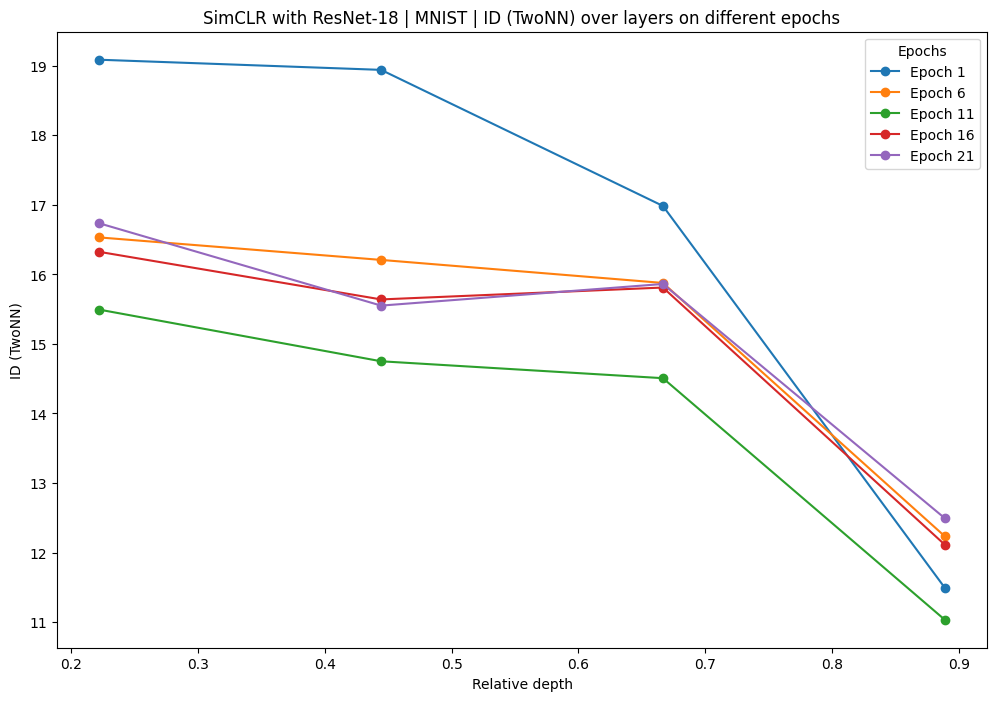

In [ ]:
plot_feature(model="SimCLR with ResNet-18", data="MNIST", feature="ID (TwoNN)", results=ids_two_nn_simclr, num_epochs=5, layers=layers_simclr, list_relative_depths=normalized_depths)

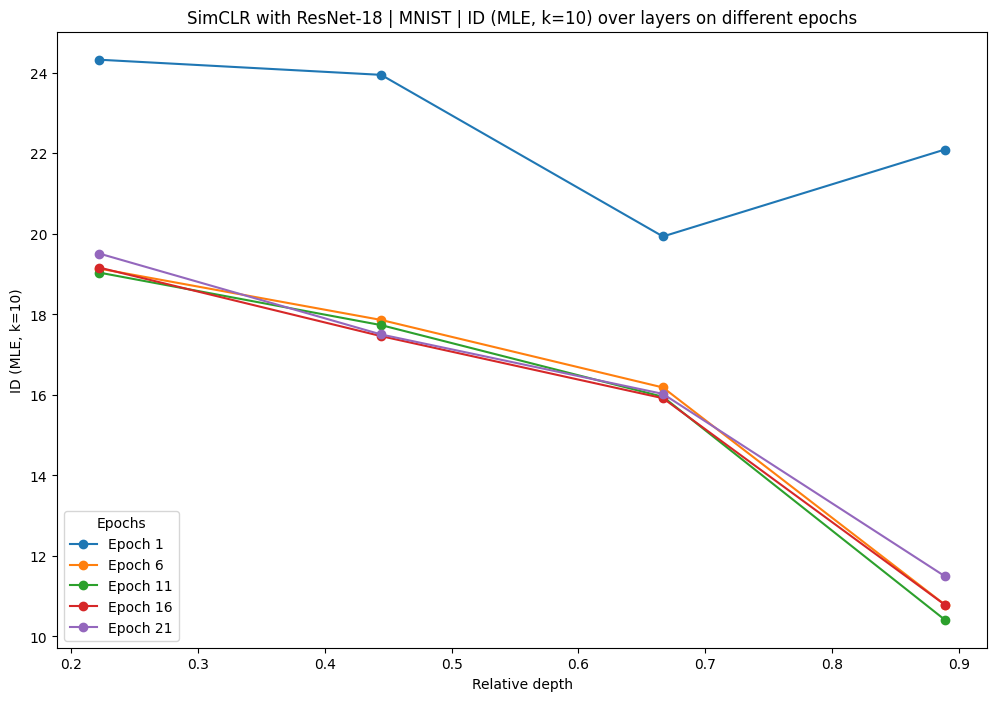

In [ ]:
plot_feature(model="SimCLR with ResNet-18", data="MNIST", feature="ID (MLE, k=10)", results=ids_mle_simclr, num_epochs=5, layers=layers_simclr, list_relative_depths=normalized_depths)

### Magnitude

In [ ]:
def magnitude_experiment(list_embs):
  magnitudes = []
  for num_emb in range(len(list_embs)):
    magnitudes.append(magnitude(list_embs[num_emb]))
  return magnitudes

In [ ]:
reduced_embs = []

for embeddings in list_embs:
    reduced_embs.append(embeddings[:1000])

for i, reduced_embeddings in enumerate(reduced_embs):
    print(f"Epoch {i+1}, Reduced Embedding shape: {reduced_embeddings.shape}")

Epoch 1, Reduced Embedding shape: (1000, 3136)
Epoch 2, Reduced Embedding shape: (1000, 2048)
Epoch 3, Reduced Embedding shape: (1000, 1024)
Epoch 4, Reduced Embedding shape: (1000, 512)
Epoch 5, Reduced Embedding shape: (1000, 3136)
Epoch 6, Reduced Embedding shape: (1000, 2048)
Epoch 7, Reduced Embedding shape: (1000, 1024)
Epoch 8, Reduced Embedding shape: (1000, 512)
Epoch 9, Reduced Embedding shape: (1000, 3136)
Epoch 10, Reduced Embedding shape: (1000, 2048)
Epoch 11, Reduced Embedding shape: (1000, 1024)
Epoch 12, Reduced Embedding shape: (1000, 512)
Epoch 13, Reduced Embedding shape: (1000, 3136)
Epoch 14, Reduced Embedding shape: (1000, 2048)
Epoch 15, Reduced Embedding shape: (1000, 1024)
Epoch 16, Reduced Embedding shape: (1000, 512)
Epoch 17, Reduced Embedding shape: (1000, 3136)
Epoch 18, Reduced Embedding shape: (1000, 2048)
Epoch 19, Reduced Embedding shape: (1000, 1024)
Epoch 20, Reduced Embedding shape: (1000, 512)


In [ ]:
magnitudes = magnitude_experiment(reduced_embs)

In [ ]:
magnitudes

[999.9999999964832,
 999.9999957364497,
 999.998575775214,
 999.9990129836177,
 999.9999999993366,
 999.999996820781,
 999.9949699687978,
 968.5180037751968,
 999.9999999999961,
 999.9999993774746,
 999.9953325218313,
 978.7406590738404,
 999.9999999999657,
 999.9999996044158,
 999.9969362485373,
 986.4655441577511,
 999.999999999832,
 999.9999971374586,
 999.9982520001004,
 988.0084743937074]

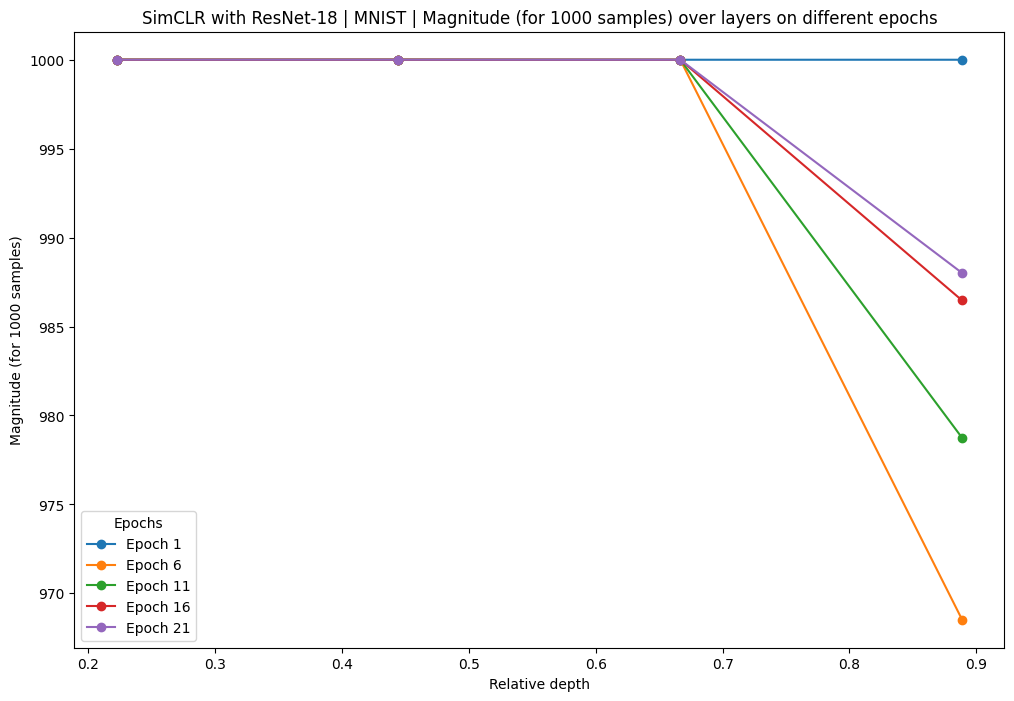

In [ ]:
plot_feature(model="SimCLR with ResNet-18", data="MNIST", feature='Magnitude (for 1000 samples)', results=magnitudes, num_epochs=5, layers=layers_simclr[-5:], list_relative_depths=normalized_depths)

### Curvature

In [ ]:
def curvature_experiment(list_embs, k=3):
  curvatures = []
  for num_emb in range(len(list_embs)):
    curvatures.append(np.ma.masked_invalid(curvature(list_embs[num_emb], k)).mean())
  return curvatures

In [ ]:
curvatures = curvature_experiment(normalized_embs)

In [ ]:
curvatures

[masked,
 masked,
 -1.0531557942878041e+266,
 -2.4300831341051155e+136,
 -1.6528986037808117e+112,
 -4590095621042272.0,
 masked,
 masked,
 masked,
 -5.183359736490712e+144,
 -1.1174545038228793e+131,
 -2.7905527212133374e+20,
 masked,
 masked,
 masked,
 -1.6832723644120752e+132,
 -1.5498368016036123e+123,
 -2.633130540504003e+16,
 masked,
 masked,
 masked,
 -1.8695131022634515e+161,
 -1.2252329255446969e+154,
 -3.8013312670756683e+23,
 masked,
 masked,
 masked,
 -1.4256895753541072e+103,
 -7.777895235409942e+113,
 -9.339527235092607e+20]

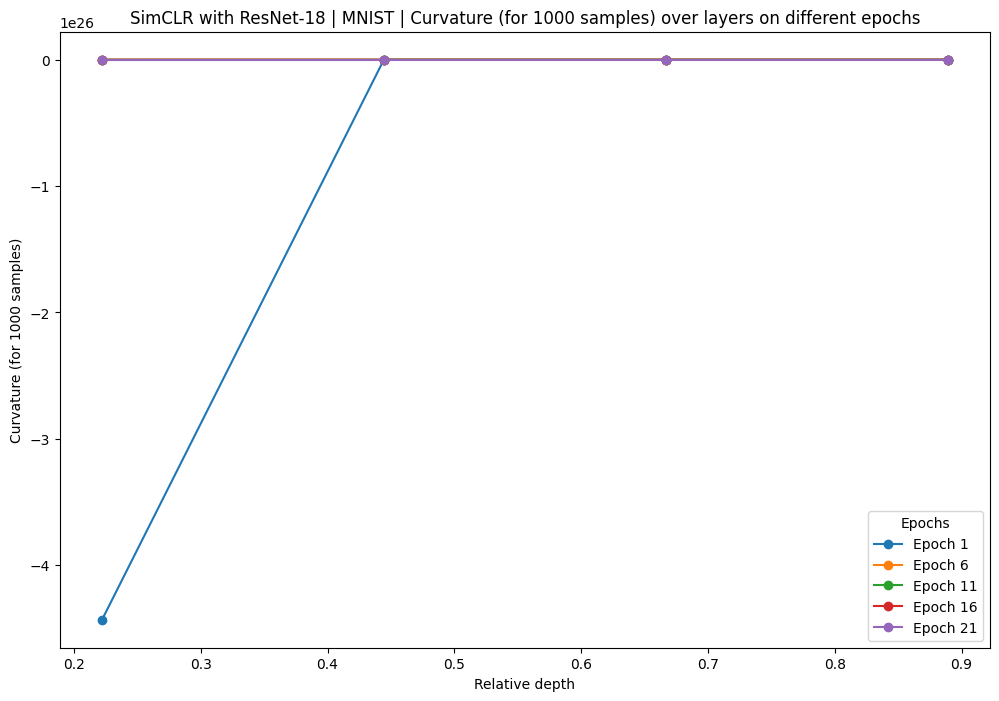

In [ ]:
plot_feature(model="SimCLR with ResNet-18", data="MNIST", feature='Curvature (for 1000 samples)', results=curvatures, num_epochs=5, layers=layers_simclr[-5:], list_relative_depths=normalized_depths)

### Persistence diagrams

In [ ]:
pip install persim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18101 sha256=77fe2bd5b93e86761e55233525e6fb44b74ed13c774c8ce2476ea7ef2c2f43fa
  Stored in directory: /root/.cache/pip/wheels/ef/0f/3b/0f931844eecc34addd90e72d54cd39c08b7066c5f25c00b9a4
Successfully built hopcroftkarp


In [ ]:
import persim
from sklearn.preprocessing import normalize

In [ ]:
reduced_embs = []

for embeddings in list_embs:
    reduced_embs.append(embeddings[:1000])

for i, reduced_embeddings in enumerate(reduced_embs):
    print(f"Epoch {i+1}, Reduced Embedding shape: {reduced_embeddings.shape}")

Epoch 1, Reduced Embedding shape: (1000, 3136)
Epoch 2, Reduced Embedding shape: (1000, 2048)
Epoch 3, Reduced Embedding shape: (1000, 1024)
Epoch 4, Reduced Embedding shape: (1000, 512)
Epoch 5, Reduced Embedding shape: (1000, 3136)
Epoch 6, Reduced Embedding shape: (1000, 2048)
Epoch 7, Reduced Embedding shape: (1000, 1024)
Epoch 8, Reduced Embedding shape: (1000, 512)
Epoch 9, Reduced Embedding shape: (1000, 3136)
Epoch 10, Reduced Embedding shape: (1000, 2048)
Epoch 11, Reduced Embedding shape: (1000, 1024)
Epoch 12, Reduced Embedding shape: (1000, 512)
Epoch 13, Reduced Embedding shape: (1000, 3136)
Epoch 14, Reduced Embedding shape: (1000, 2048)
Epoch 15, Reduced Embedding shape: (1000, 1024)
Epoch 16, Reduced Embedding shape: (1000, 512)
Epoch 17, Reduced Embedding shape: (1000, 3136)
Epoch 18, Reduced Embedding shape: (1000, 2048)
Epoch 19, Reduced Embedding shape: (1000, 1024)
Epoch 20, Reduced Embedding shape: (1000, 512)


In [ ]:
normalized_embs = []
for emb in reduced_embs:
  normalized_embs.append(normalize(emb, axis=0, norm='max'))

In [ ]:
def get_vr_diagrams(normalized_embs):
  vrs = []
  for i in range(len(normalized_embs)):
    vrs.append(drop_inf(vr_diagrams(normalized_embs[i])))
  return vrs

In [ ]:
vrs = get_vr_diagrams(normalized_embs)
vrs

[[array([[ 0.       ,  3.5725684],
         [ 0.       ,  3.6767871],
         [ 0.       ,  3.7261617],
         ...,
         [ 0.       , 14.820585 ],
         [ 0.       , 14.865767 ],
         [ 0.       , 15.500716 ]], dtype=float32),
  array([[14.930616 , 14.954631 ],
         [14.929781 , 15.275088 ],
         [14.591104 , 14.637769 ],
         ...,
         [ 4.5617123,  4.565309 ],
         [ 4.4363117,  4.5386405],
         [ 4.429324 ,  4.496903 ]], dtype=float32)],
 [array([[ 0.       ,  3.4702795],
         [ 0.       ,  3.4747386],
         [ 0.       ,  3.6002114],
         ...,
         [ 0.       , 11.801917 ],
         [ 0.       , 12.152325 ],
         [ 0.       , 12.390132 ]], dtype=float32),
  array([[11.916707 , 12.033744 ],
         [11.831843 , 11.892747 ],
         [11.455329 , 11.491764 ],
         ...,
         [ 4.310597 ,  4.4515886],
         [ 4.172107 ,  4.2168055],
         [ 4.137793 ,  4.316652 ]], dtype=float32)],
 [array([[0.       , 2.144802 ],
 

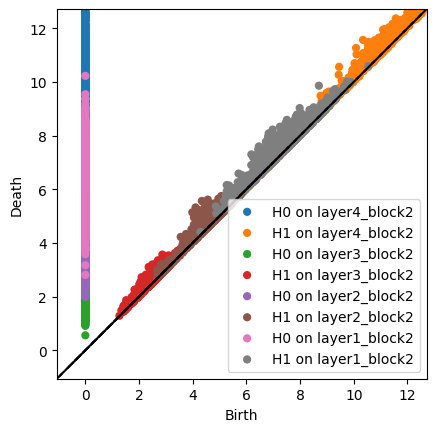

In [ ]:
for i in range(4):
  persim.plot_diagrams(vrs[-i], labels=[f'H0 on {layers_simclr[-i-1]}', f'H1 on {layers_simclr[-i-1]}'], size=35)

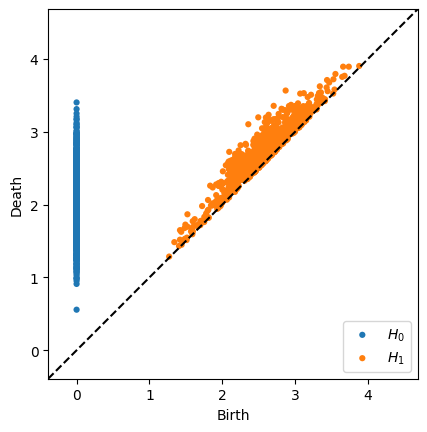

In [ ]:
persim.plot_diagrams(vrs[-1])

In [ ]:
layers_simclr.sort()

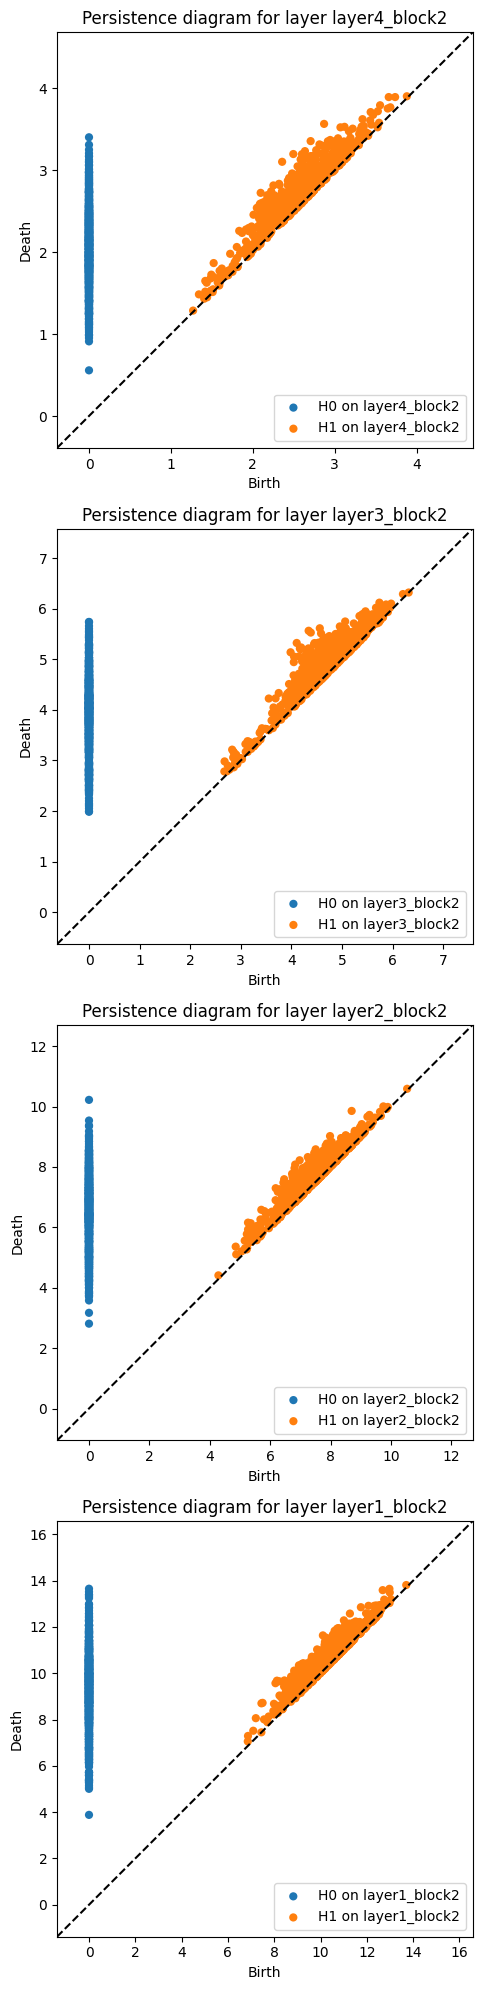

In [ ]:
num_diagrams = 4 # Number of diagrams to plot
fig, axes = plt.subplots(num_diagrams, 1, figsize=(10, num_diagrams * 5))

for i in range(num_diagrams):
    ax = axes[i]
    persim.plot_diagrams(vrs[-(i+1)], labels=[f'H0 on {layers_simclr[-(i+1)]}', f'H1 on {layers_simclr[-(i+1)]}'], size=35, ax=ax)
    ax.set_title(f'Persistence diagram for layer {layers_simclr[-(i+1)]}')

plt.tight_layout()
plt.show()

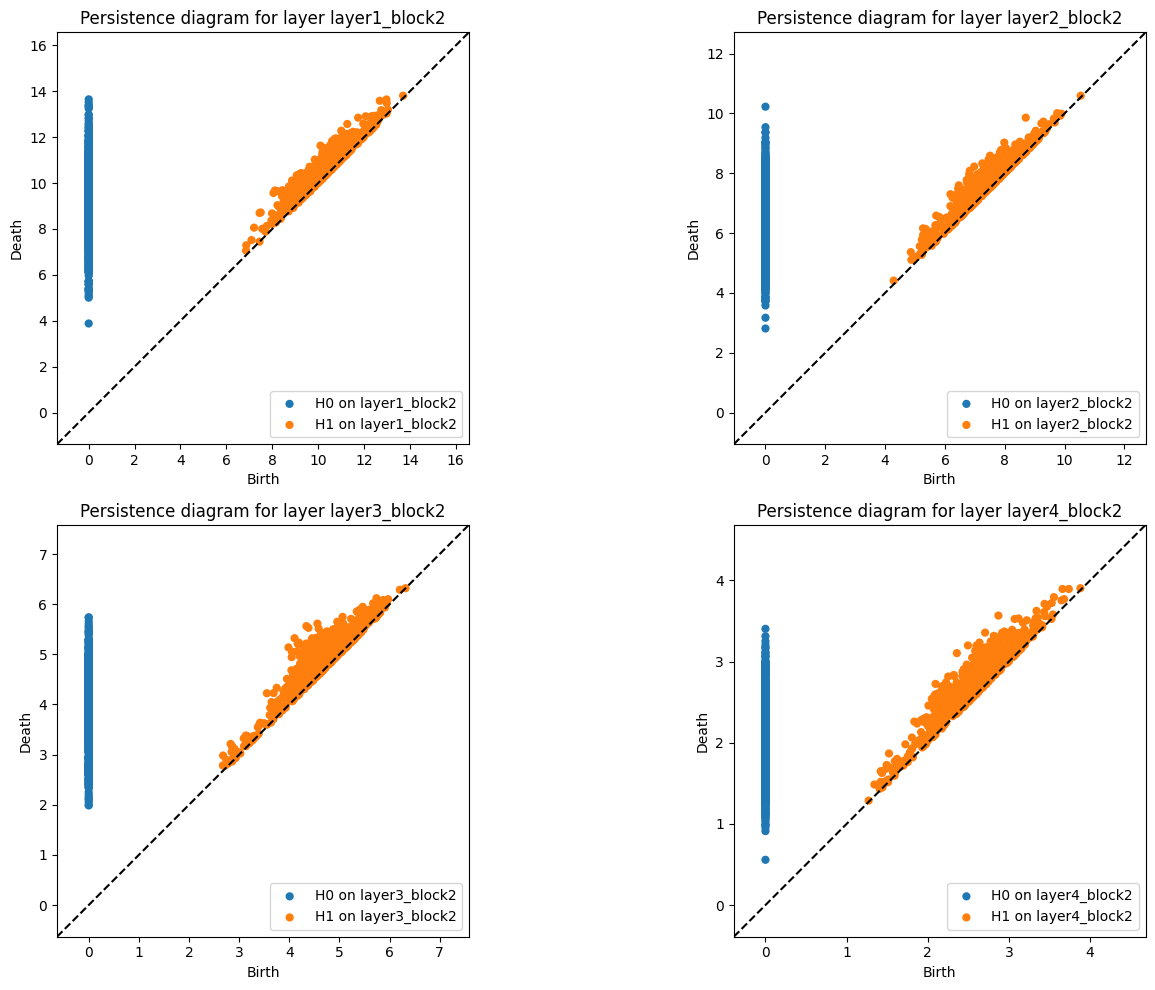

In [ ]:
num_diagrams = 4  # Number of diagrams to plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2 rows, 3 columns

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each persistence diagram in a subplot
for i in range(num_diagrams):
    ax = axes[i]
    persim.plot_diagrams(vrs[-(num_diagrams-i)], labels=[f'H0 on {layers_simclr[-(num_diagrams-i)]}', f'H1 on {layers_simclr[-(num_diagrams-i)]}'], size=35, ax=ax)
    ax.set_title(f'Persistence diagram for layer {layers_simclr[-(num_diagrams-i)]}')

# Hide any empty subplots (if fewer than 6 diagrams)
for j in range(num_diagrams, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


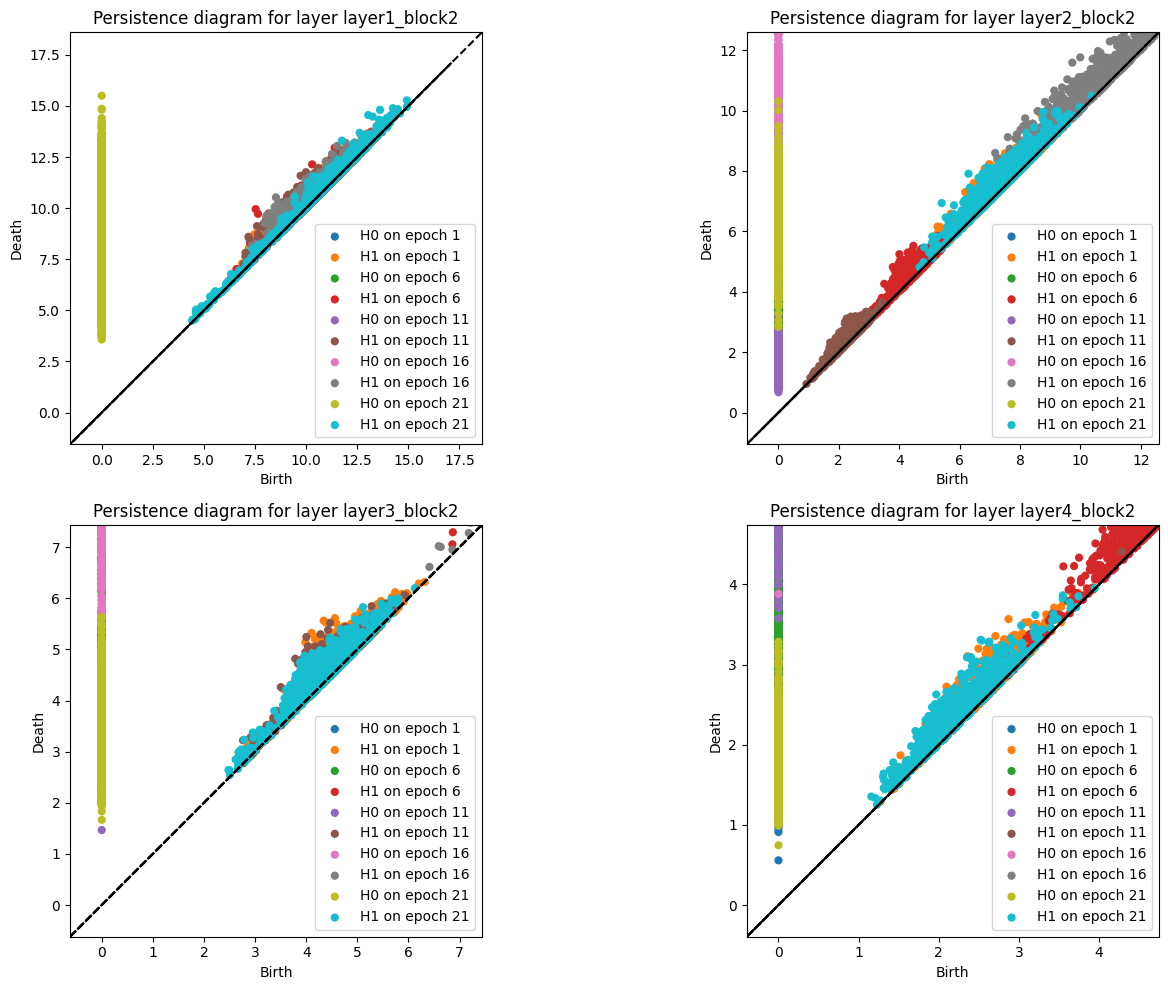

In [ ]:
num_diagrams = 4  # Number of diagrams to plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2 rows, 3 columns

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each persistence diagram in a subplot
for i in range(num_diagrams):
    ax = axes[i]
    for epoch in range(1,6):
      persim.plot_diagrams(vrs[-epoch*(num_diagrams-i)], labels=[f'H0 on epoch {epoch*5-4}', f'H1 on epoch {epoch*5-4}'], size=35, ax=ax)
      ax.set_title(f'Persistence diagram for layer {layers_simclr[-(num_diagrams-i)]}')

# Hide any empty subplots (if fewer than 6 diagrams)
for j in range(num_diagrams, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Total persistence

In [ ]:
def total_persistence_experiment(vrs, q):
  total_persistences = []
  for num_emb in range(len(vrs)):
    total_persistences.append(total_persistence(vrs[num_emb], q))
    print(f'Epoch: {list_epochs[num_emb]} | Layer: {list_layers[num_emb]} | Total persistence: {total_persistences[num_emb]}')
  return total_persistences

In [ ]:
total_p_half = total_persistence_experiment(vrs, q=0.5)

Epoch: 1 | Layer: layer1_block2 | Total persistence: 3228.05810546875
Epoch: 1 | Layer: layer2_block2 | Total persistence: 2887.457763671875
Epoch: 1 | Layer: layer3_block2 | Total persistence: 2377.64697265625
Epoch: 1 | Layer: layer4_block2 | Total persistence: 2185.906982421875
Epoch: 6 | Layer: layer1_block2 | Total persistence: 3567.361328125
Epoch: 6 | Layer: layer2_block2 | Total persistence: 3097.58056640625
Epoch: 6 | Layer: layer3_block2 | Total persistence: 2272.38818359375
Epoch: 6 | Layer: layer4_block2 | Total persistence: 1538.68994140625
Epoch: 11 | Layer: layer1_block2 | Total persistence: 3627.9111328125
Epoch: 11 | Layer: layer2_block2 | Total persistence: 3115.290771484375
Epoch: 11 | Layer: layer3_block2 | Total persistence: 2363.55810546875
Epoch: 11 | Layer: layer4_block2 | Total persistence: 1620.4306640625
Epoch: 16 | Layer: layer1_block2 | Total persistence: 3638.642578125
Epoch: 16 | Layer: layer2_block2 | Total persistence: 3111.9453125
Epoch: 16 | Layer: la

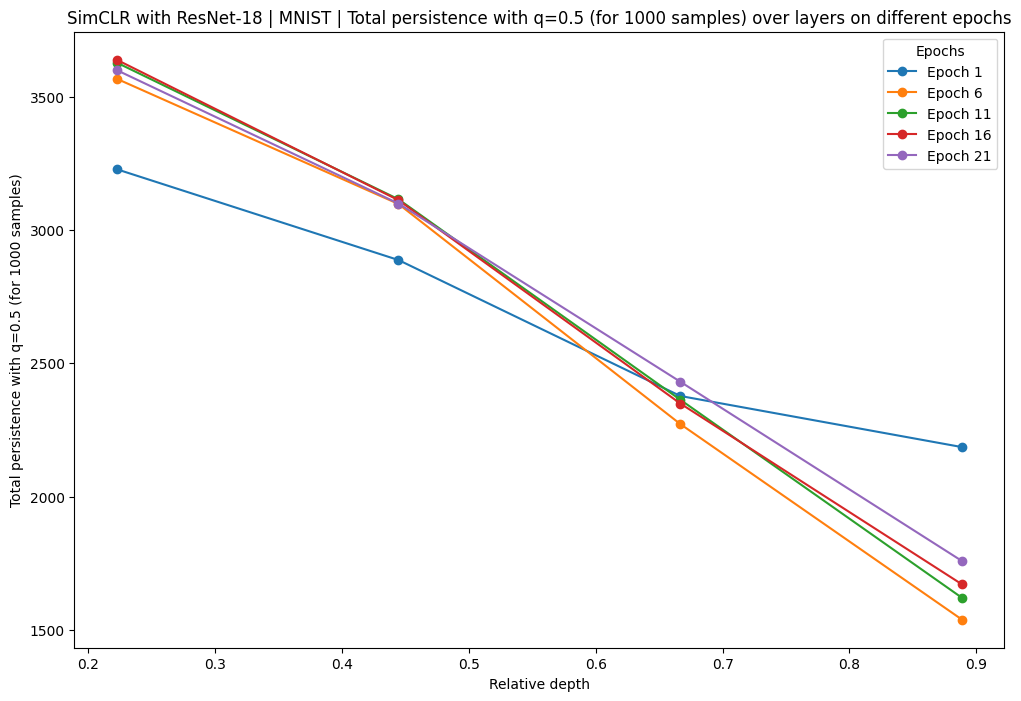

In [ ]:
plot_feature(model="SimCLR with ResNet-18", data="MNIST", feature='Total persistence with q=0.5 (for 1000 samples)', results=total_p_half, num_epochs=5, layers=layers_simclr[-4:], list_relative_depths=normalized_depths)

In [ ]:
total_p_full = total_persistence_experiment(vrs, q=1)

Epoch: 1 | Layer: layer1_block2 | Total persistence: 9124.54296875
Epoch: 1 | Layer: layer2_block2 | Total persistence: 7483.59375
Epoch: 1 | Layer: layer3_block2 | Total persistence: 5007.9990234375
Epoch: 1 | Layer: layer4_block2 | Total persistence: 4210.818359375
Epoch: 6 | Layer: layer1_block2 | Total persistence: 9571.23828125
Epoch: 6 | Layer: layer2_block2 | Total persistence: 6737.4541015625
Epoch: 6 | Layer: layer3_block2 | Total persistence: 3699.119873046875
Epoch: 6 | Layer: layer4_block2 | Total persistence: 1729.8994140625
Epoch: 11 | Layer: layer1_block2 | Total persistence: 9705.37109375
Epoch: 11 | Layer: layer2_block2 | Total persistence: 6876.99853515625
Epoch: 11 | Layer: layer3_block2 | Total persistence: 3933.237060546875
Epoch: 11 | Layer: layer4_block2 | Total persistence: 1877.7449951171875
Epoch: 16 | Layer: layer1_block2 | Total persistence: 9794.5537109375
Epoch: 16 | Layer: layer2_block2 | Total persistence: 6871.375
Epoch: 16 | Layer: layer3_block2 | Tota

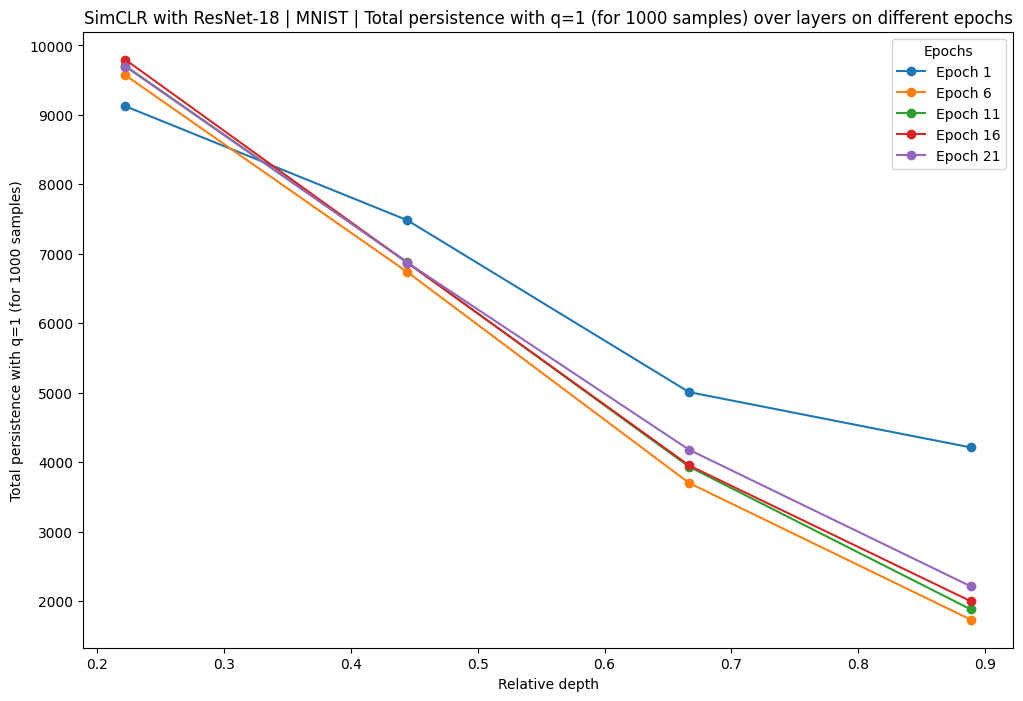

In [ ]:
plot_feature(model="SimCLR with ResNet-18", data="MNIST", feature='Total persistence with q=1 (for 1000 samples)', results=total_p_full, num_epochs=5, layers=layers_simclr[-4:], list_relative_depths=normalized_depths)

### Persistence entropy

In [ ]:
from intrinsic.functional.homology import persistence_entropy

In [ ]:
vrs[0][1]

array([[14.930616 , 14.954631 ],
       [14.929781 , 15.275088 ],
       [14.591104 , 14.637769 ],
       ...,
       [ 4.5617123,  4.565309 ],
       [ 4.4363117,  4.5386405],
       [ 4.429324 ,  4.496903 ]], dtype=float32)

In [ ]:
def persistence_entropy_experiment(vrs):
  persistence_entropies = []
  for num_emb in range(len(vrs)):
    persistence_entropies.append(persistence_entropy(vrs[num_emb]))
    print(f'Epoch: {list_epochs[num_emb]} | Layer: {list_layers[num_emb]} | Persistent entropies (for H0, H1): {persistence_entropies[num_emb]}')
  return persistence_entropies

In [ ]:
persistent_entropies = persistence_entropy_experiment(vrs)

Epoch: 1 | Layer: layer1_block2 | Persistent entropies (for H0, H1): [6.86821   6.0072303]
Epoch: 1 | Layer: layer2_block2 | Persistent entropies (for H0, H1): [6.8786716 5.921482 ]
Epoch: 1 | Layer: layer3_block2 | Persistent entropies (for H0, H1): [6.8764257 6.0467906]
Epoch: 1 | Layer: layer4_block2 | Persistent entropies (for H0, H1): [6.8903103 6.037171 ]
Epoch: 6 | Layer: layer1_block2 | Persistent entropies (for H0, H1): [6.8922386 6.5615396]
Epoch: 6 | Layer: layer2_block2 | Persistent entropies (for H0, H1): [6.8920164 6.737172 ]
Epoch: 6 | Layer: layer3_block2 | Persistent entropies (for H0, H1): [6.892337 6.561877]
Epoch: 6 | Layer: layer4_block2 | Persistent entropies (for H0, H1): [6.8820496 6.3104   ]
Epoch: 11 | Layer: layer1_block2 | Persistent entropies (for H0, H1): [6.8929873 6.639137 ]
Epoch: 11 | Layer: layer2_block2 | Persistent entropies (for H0, H1): [6.8924084 6.737126 ]
Epoch: 11 | Layer: layer3_block2 | Persistent entropies (for H0, H1): [6.8921723 6.626773 

In [ ]:
persistent_entropies

[array([6.86821  , 6.0072303], dtype=float32),
 array([6.8786716, 5.921482 ], dtype=float32),
 array([6.8764257, 6.0467906], dtype=float32),
 array([6.8903103, 6.037171 ], dtype=float32),
 array([6.8922386, 6.5615396], dtype=float32),
 array([6.8920164, 6.737172 ], dtype=float32),
 array([6.892337, 6.561877], dtype=float32),
 array([6.8820496, 6.3104   ], dtype=float32),
 array([6.8929873, 6.639137 ], dtype=float32),
 array([6.8924084, 6.737126 ], dtype=float32),
 array([6.8921723, 6.626773 ], dtype=float32),
 array([6.88203  , 6.3828545], dtype=float32),
 array([6.89357 , 6.655575], dtype=float32),
 array([6.893299 , 6.7394886], dtype=float32),
 array([6.894425 , 6.5584593], dtype=float32),
 array([6.883893, 6.417976], dtype=float32),
 array([6.89423 , 6.605413], dtype=float32),
 array([6.8926125, 6.7241936], dtype=float32),
 array([6.891968, 6.606424], dtype=float32),
 array([6.885314, 6.466587], dtype=float32)]

### RTD Score between the embeddings

In [ ]:
from intrinsic.functional.homology import wasserstein_distance, rtd

In [ ]:
rtd(normalized_embs[-1], normalized_embs[-2])

array([  0.        , 109.64613891])

In [ ]:
rtd(normalized_embs[-1], normalized_embs[-5])

array([  0.        , 762.11422622])

In [ ]:
rtd(normalized_embs[-2], normalized_embs[-6])

array([   0.        , 1101.37126017])

In [ ]:
rtd(normalized_embs[-1], normalized_embs[-9])

array([  0.        , 827.74979717])

In [ ]:
rtd(normalized_embs[-1], normalized_embs[-13])

array([  0.        , 878.16023594])